# Deskriptivní analýza a predikce pomocí modelů Prophet, XGBoost a LSMT

**Fázi 1. "Příprava dat" je nutné vždy spustit pro vygenerování a ošetření dále používané kopie datasetu. Všechny ostatní části fungují nezávisle na sobě.**

## 1. Příprava dat

In [ ]:
# KAPITOLA 1: PŘÍPRAVA DAT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

print("## KAPITOLA 1: PŘÍPRAVA DAT ##")

# 1.1 Načtení datasetu
print("\n1.1 Načtení datasetu OWID COVID-19")
url = "https://catalog.ourworldindata.org/garden/covid/latest/compact/compact.csv"
df = pd.read_csv(url)
print(f"Načteno {df.shape[0]} řádků a {df.shape[1]} sloupců dat.")

# 1.2 Průzkum struktury dat
print("\n1.2 Základní informace o datasetu:")
print(f"Tvar datasetu: {df.shape}")
print(f"Hlavička datasetu: {df.columns}")

# 1.3 Identifikace a popis klíčových sloupců
key_columns = ['country', 'date', 'total_cases', 'total_deaths', 'new_cases',
              'new_deaths', 'population', 'gdp_per_capita', 'continent',
              'human_development_index', 'stringency_index', 'people_vaccinated']

print("\n1.3 Popis klíčových sloupců:")
for col in key_columns:
    if col in df.columns:
        print(f" - {col}: {df[col].dtype}")

# 1.4 Kontrola a zpracování chybějících hodnot
print("\n1.4 Kontrola chybějících hodnot v klíčových sloupcích:")
missing_in_key = {col: df[col].isnull().sum() for col in key_columns if col in df.columns}
for col, missing in missing_in_key.items():
    pct = (missing / len(df)) * 100
    print(f" - {col}: {missing} chybějících hodnot ({pct:.2f}%)")

# 1.5 Vytvoření čisté kopie dataframu a základní transformace
df_clean = df.copy()

# Převod data na datetime formát
if 'date' in df_clean.columns:
    df_clean['date'] = pd.to_datetime(df_clean['date'])
    print("\n1.5 Převod sloupce 'date' na datetime formát dokončen.")

# Vytvoření nových časových proměnných pro použití v další analýze
if 'date' in df_clean.columns:
    df_clean['month'] = df_clean['date'].dt.month
    df_clean['year'] = df_clean['date'].dt.year
    df_clean['month_year'] = df_clean['date'].dt.strftime('%Y-%m')
    print("Vytvořeny nové časové sloupce: month, year, month_year")

# 1.6 Vytvoření dodatečných analytických proměnných
if all(col in df_clean.columns for col in ['total_deaths', 'total_cases']):
    # Výpočet míry úmrtnosti
    df_clean['case_fatality_rate'] = (df_clean['total_deaths'] / df_clean['total_cases'] * 100)
    # Nahrazení NaN a Inf hodnot tam, kde je total_cases = 0
    df_clean['case_fatality_rate'] = df_clean['case_fatality_rate'].replace([np.inf, -np.inf], np.nan)
    print("\n1.6 Vytvořen nový sloupec 'case_fatality_rate' (procento úmrtí z potvrzených případů).")

# 1.7 Nahrazení chybějících hodnot v klíčových sloupcích
for col in ['new_cases', 'new_deaths']:
    if col in df_clean.columns:
        # Nahrazení chybějících hodnot po skupinách podle lokace
        df_clean[col] = df_clean.groupby('country')[col].transform(
            lambda x: x.ffill().fillna(0))
print("\n1.7 Nahrazení chybějících hodnot v klíčových časových řadách dokončeno.")

print("\n1.8 Vytvoření datové sady s nejnovějšími nenulovými údaji pro každou zemi")

# Seznam důležitých sloupců
important_columns = ['total_cases', 'total_deaths', 'total_cases_per_million',
                    'total_deaths_per_million', 'people_fully_vaccinated_per_hundred' ]

def get_latest_nonzero(group, column):
    valid_data = group[group[column] > 0].dropna(subset=[column])
    if not valid_data.empty:
        return valid_data.iloc[-1][column]
    latest_data = group.dropna(subset=[column])
    if not latest_data.empty:
        return latest_data.iloc[-1][column]
    return np.nan

# Vytvoření prázdného dataframu pro sběr nejnovějších hodnot
latest_by_country = pd.DataFrame()

# Získání seznamu všech zemí
countries = df['country'].unique()

# Sběr dat pro každou zemi
for country in countries:
    country_data = df[df['country'] == country].sort_values('date')
    if country_data.empty:
        continue
    latest_record = country_data.iloc[-1].copy()

    for column in important_columns:
        if column in country_data.columns:
            latest_record[column] = get_latest_nonzero(country_data, column)
    latest_by_country = pd.concat([latest_by_country, pd.DataFrame([latest_record])], ignore_index=True)

print(f"Vytvořena datová sada s nejnovějšími údaji o státech.")

# Vytvoření case_fatality_rate v latest_by_country
if 'total_deaths' in latest_by_country.columns and 'total_cases' in latest_by_country.columns:
    latest_by_country['case_fatality_rate'] = (latest_by_country['total_deaths'] /
                                              latest_by_country['total_cases'] * 100)
    # Nahrazení chybějících hodnot
    latest_by_country['case_fatality_rate'] = latest_by_country['case_fatality_rate'].replace([np.inf, -np.inf], np.nan)
    print("Sloupec 'case_fatality_rate' byl vytvořen v latest_by_country.")
else:
    print("Nelze vytvořit case_fatality_rate - chybí potřebné sloupce v latest_by_country.")

# Finální dataset pro analýzu
df = df_clean.copy()
print("\nPříprava dat dokončena. Dataset je připraven pro další analýzu.")

## KAPITOLA 1: PŘÍPRAVA DAT ##

1.1 Načtení datasetu OWID COVID-19
Načteno 485796 řádků a 61 sloupců dat.

1.2 Základní informace o datasetu:
Tvar datasetu: (485796, 61)
Hlavička datasetu: Index(['country', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed',
       'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'excess_mortality', 'excess_mortality_cumulative',
       'excess_mortality_cumulative_absolute',
       'excess_mortality_cumulative_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'icu_patients',
       'icu_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'stringency_index',
       'reproduction_rate', 'total_tests', 'new_tests',
    

## 2. Analýza šíření ve světě

## KAPITOLA 2: ANALÝZA ŠÍŘENÍ COVID-19 VE SVĚTĚ ##

2.1 Globální trend šíření COVID-19


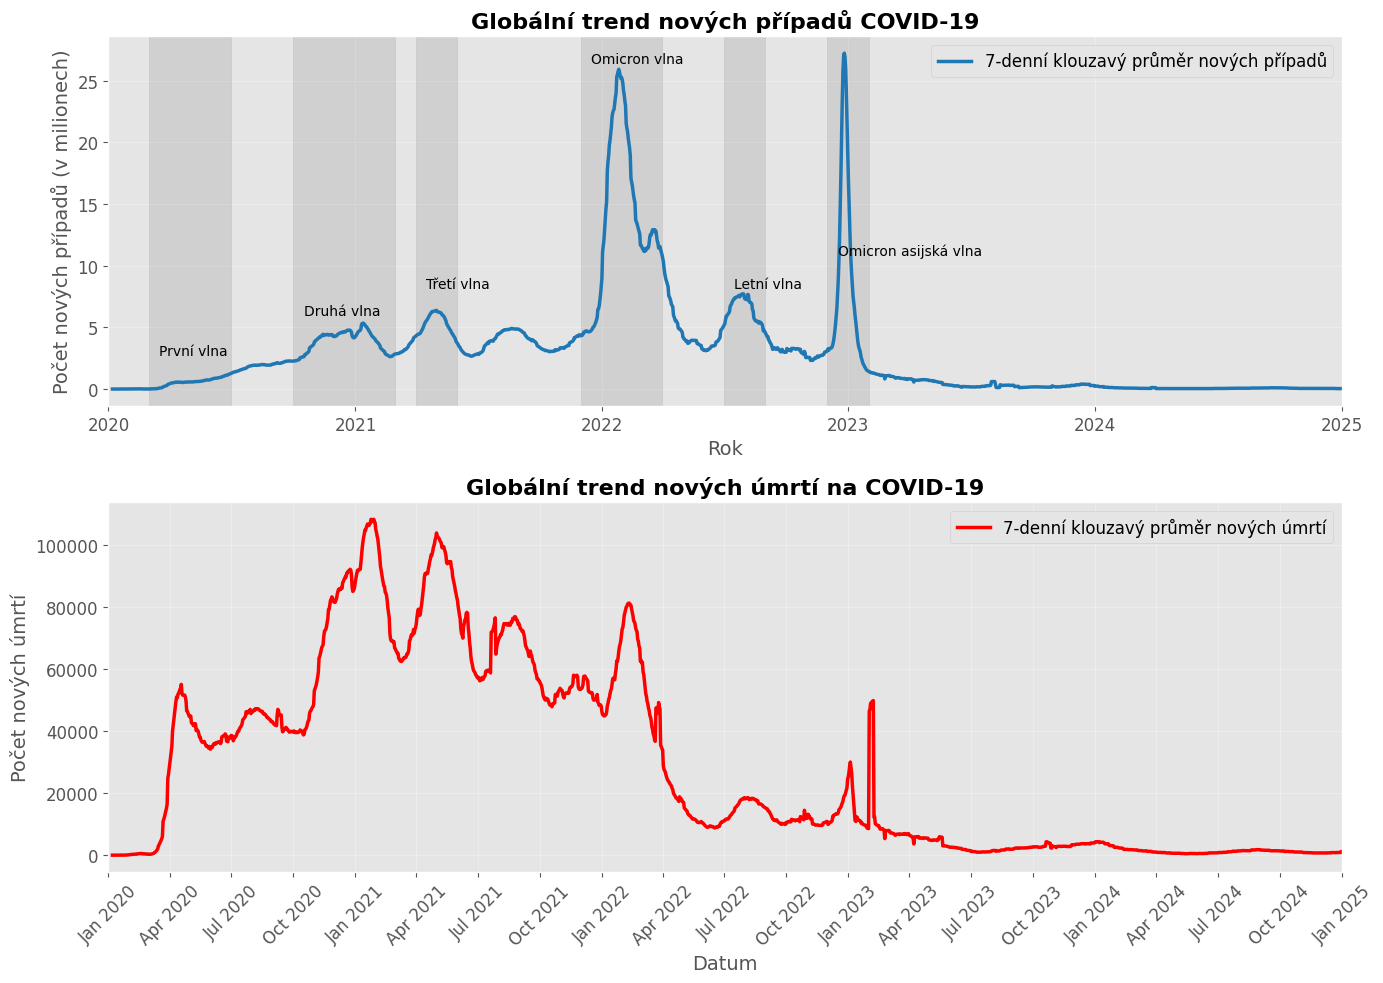


Vrcholy pandemie podle nových případů:
          Datum  Průměrný denní počet nových případů
1090 2022-12-26                         2.722490e+07
1089 2022-12-25                         2.694644e+07
1091 2022-12-27                         2.692043e+07

Vrcholy pandemie podle nových úmrtí:
         Datum  Průměrný denní počet nových úmrtí
393 2021-01-28                      108242.142857
389 2021-01-24                      108241.428571
390 2021-01-25                      107900.285714


In [ ]:
# KAPITOLA 2: ANALÝZA ŠÍŘENÍ COVID-19 VE SVĚTĚ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import plotly.express as px
import warnings

print("## KAPITOLA 2: ANALÝZA ŠÍŘENÍ COVID-19 VE SVĚTĚ ##")

# 2. Globální trend šíření COVID-19
print("\n2.1 Globální trend šíření COVID-19")

    # Agregace dat na globální úrovni podle datumu
if 'date' in df.columns and 'new_cases' in df.columns and 'new_deaths' in df.columns:
    global_data = df.groupby('date').agg({
        'new_cases': 'sum',
        'new_deaths': 'sum',
        'total_cases': 'max',
        'total_deaths': 'max'
    }).reset_index()

    # Vyhlazení dat pomocí 7denního klouzavého průměru
    global_data['new_cases_smoothed'] = global_data['new_cases'].rolling(7).mean()
    global_data['new_deaths_smoothed'] = global_data['new_deaths'].rolling(7).mean()


    # Vizualizace globálního trendu
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Nové případy
    axes[0].plot(global_data['date'], global_data['new_cases_smoothed'],
                 label='7-denní klouzavý průměr nových případů', color='#1f77b4', linewidth=2.5)
    axes[0].set_title('Globální trend nových případů COVID-19', fontweight='bold')
    axes[0].set_xlabel('Rok')
    axes[0].set_ylabel('Počet nových případů (v milionech)')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1e6)}'))
    axes[0].set_xlim([pd.Timestamp("2020-01-01"), pd.Timestamp("2025-01-01")])


    # Označení významných vln pandemie
    for wave_start, wave_end, wave_name, height in [
         ('2020-03-01', '2020-06-30', 'První vlna', global_data['new_cases_smoothed'].max() * 0.1),
         ('2020-10-01', '2021-02-28', 'Druhá vlna', global_data['new_cases_smoothed'].max() * 0.22),
         ('2021-04-01', '2021-05-31', 'Třetí vlna', global_data['new_cases_smoothed'].max() * 0.3),
         ('2021-12-01', '2022-03-31', 'Omicron vlna', global_data['new_cases_smoothed'].max() * 0.97),
         ('2022-07-01', '2022-08-31', 'Letní vlna', global_data['new_cases_smoothed'].max() * 0.3),
         ('2022-12-01', '2023-01-31', 'Omicron asijská vlna', global_data['new_cases_smoothed'].max() * 0.4)
      ]:
       axes[0].axvspan(pd.to_datetime(wave_start), pd.to_datetime(wave_end), alpha=0.2, color='gray')
       axes[0].text(pd.to_datetime(wave_start) + pd.Timedelta(days=15), height, wave_name, fontsize=10)

    # Nová úmrtí
    axes[1].plot(global_data['date'], global_data['new_deaths_smoothed'],
                color='red', label='7-denní klouzavý průměr nových úmrtí', linewidth=2.5)
    axes[1].set_title('Globální trend nových úmrtí na COVID-19', fontweight='bold')
    axes[1].set_xlabel('Datum')
    axes[1].set_ylabel('Počet nových úmrtí')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    axes[1].set_xlim([pd.Timestamp("2020-01-01"), pd.Timestamp("2025-01-01")])

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Tabulka s přehledem vrcholů pandemie
    peaks = global_data.nlargest(3, 'new_cases_smoothed')[['date', 'new_cases_smoothed']].rename(
         columns={'date': 'Datum', 'new_cases_smoothed': 'Průměrný denní počet nových případů'})
    print("\nVrcholy pandemie podle nových případů:")
    print(peaks)

    peaks_deaths = global_data.nlargest(3, 'new_deaths_smoothed')[['date', 'new_deaths_smoothed']].rename(
         columns={'date': 'Datum', 'new_deaths_smoothed': 'Průměrný denní počet nových úmrtí'})
    print("\nVrcholy pandemie podle nových úmrtí:")
    print(peaks_deaths)


## 3. Analýza šíření v ČR

## KAPITOLA 3: ŠÍŘENÍ NEMOCI V ČR ##

3.1 Trend šíření nemoci v ČR a Evropě


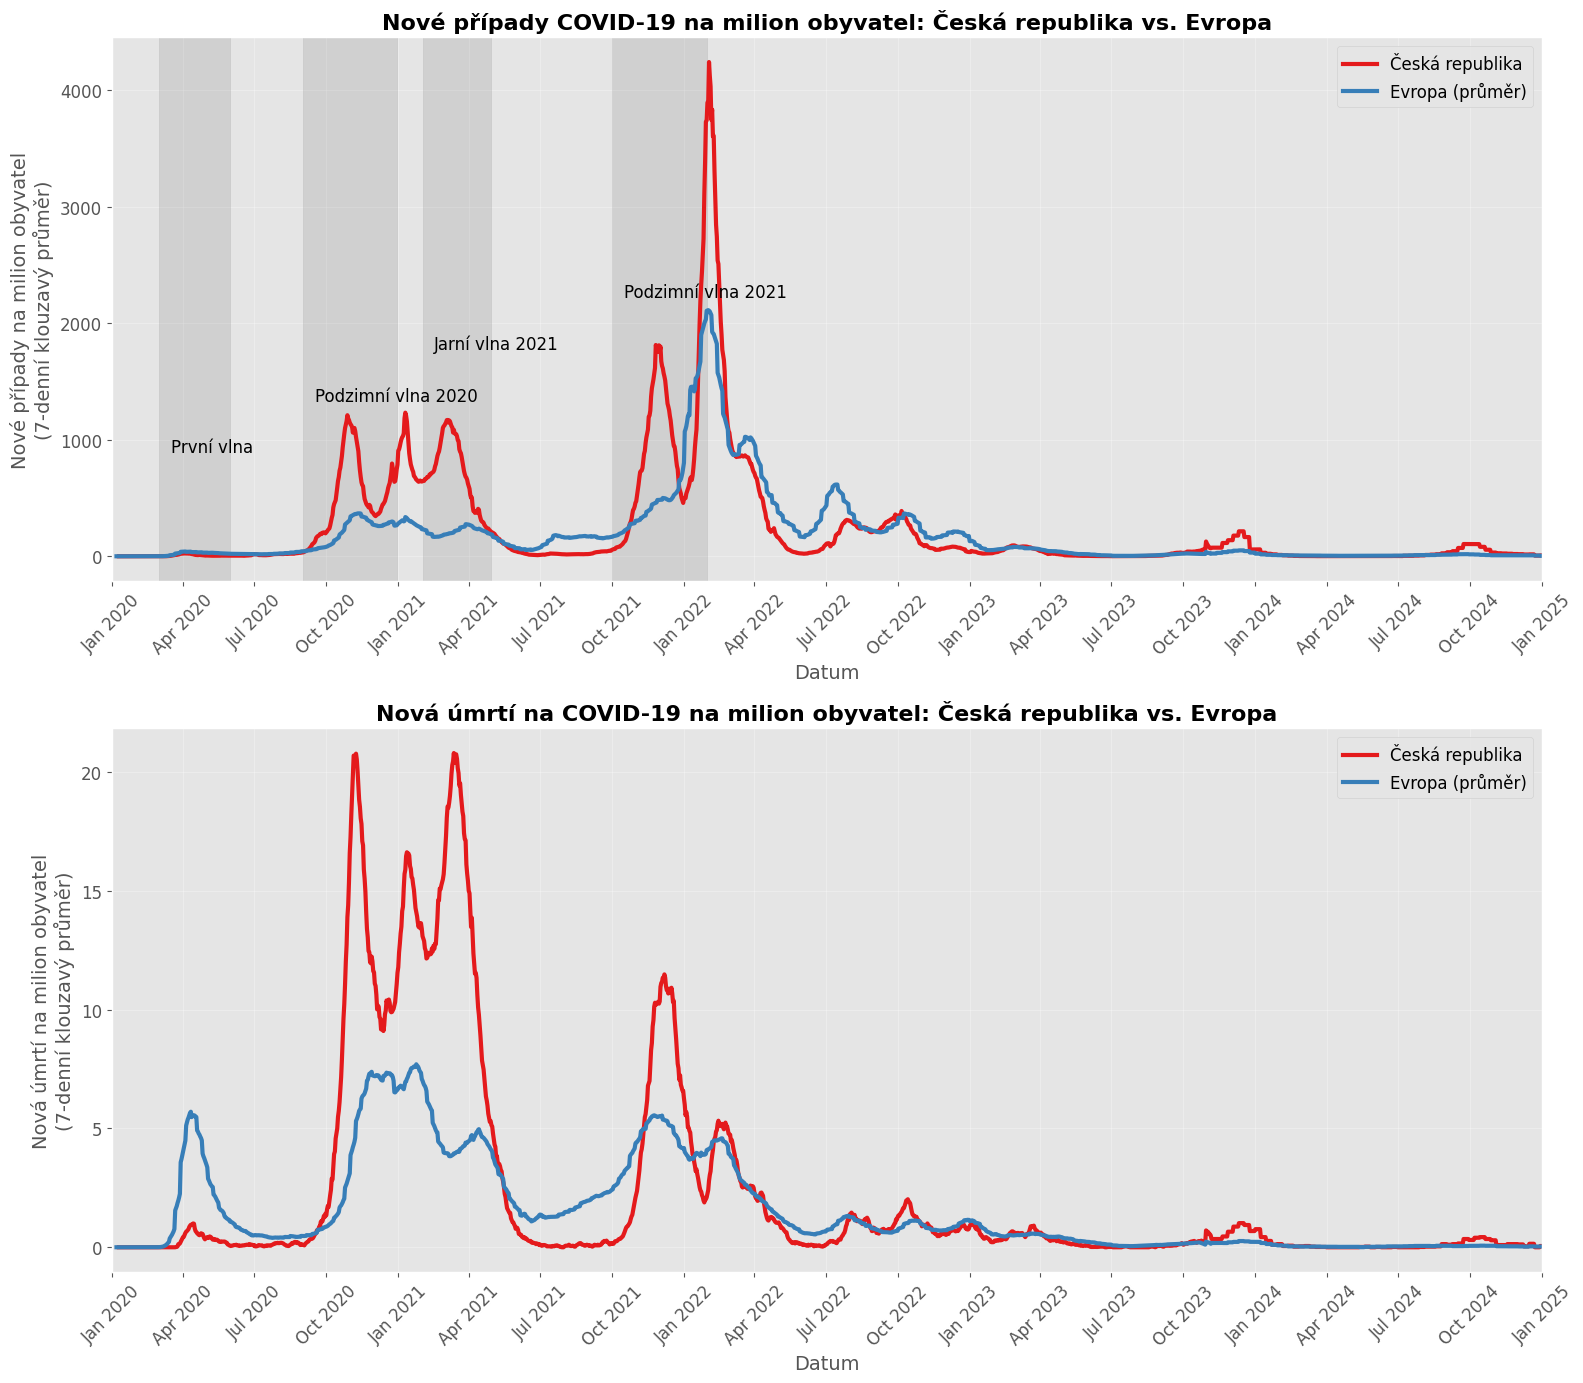


3.2 Srovnání ČR s okolními zeměmi


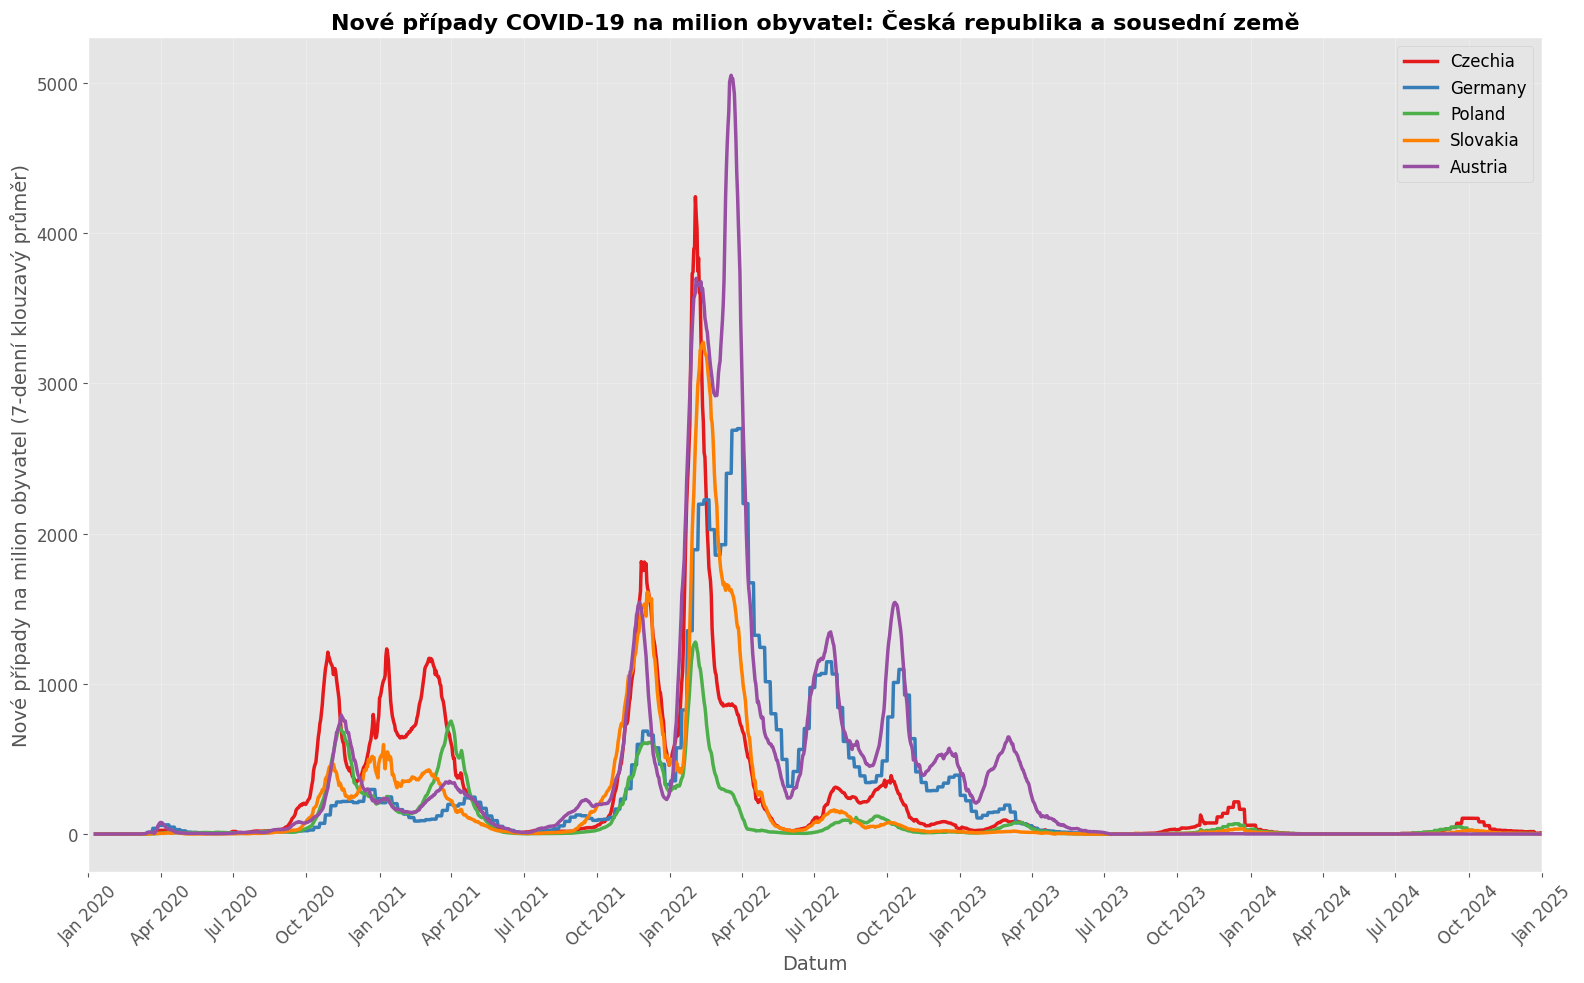


3.3 Statistické shrnutí pro ČR

Statistické shrnutí pro Českou republiku:
 - Celkem případů: 4,828,163.00
 - Celkem úmrtí: 43,807.00
 - Případů na milion: 452,362.53
 - Úmrtí na milion: 4,104.39
 - Plně očkovaní (%): 64.61

Porovnání ČR s evropským průměrem:
              Metrika  Česká republika  Evropský průměr
0   Případů na milion    452362.530000    402830.861765
1     Úmrtí na milion      4104.386000      2679.038281
2  Míra úmrtnosti (%)         0.907322         0.828860


In [ ]:
# KAPITOLA 3: ANALÝZA ŠÍŘENÍ NEMOCI V ČR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import plotly.express as px
import warnings

print("## KAPITOLA 3: ŠÍŘENÍ NEMOCI V ČR ##")

# Data pro Českou republiku
czechia_data = df[df['country'] == 'Czechia'].copy()

if not czechia_data.empty:
    czechia_data['new_cases_smoothed_czechia'] = czechia_data['new_cases'].rolling(7).mean()
    czechia_data['new_deaths_smoothed_czechia'] = czechia_data['new_deaths'].rolling(7).mean()


    # Zvýraznění vln pandemie v ČR
    cz_waves = [
        ('2020-03-01', '2020-05-31', 'První vlna'),
        ('2020-09-01', '2020-12-31', 'Podzimní vlna 2020'),
        ('2021-02-01', '2021-04-30', 'Jarní vlna 2021'),
        ('2021-10-01', '2022-01-31', 'Podzimní vlna 2021')
    ]

    # 3.1 Trend šíření nemoci v ČR a Evropě
    print("\n3.1 Trend šíření nemoci v ČR a Evropě")

    # Data pro Evropu
    europe_data = df[df['continent'] == 'Europe'].copy()

    # Agregace dat pro Evropu
    europe_agg = europe_data.groupby('date').agg({
        'new_cases': 'sum',
        'new_deaths': 'sum',
        'population': 'sum'
    }).reset_index()

    # Výpočet hodnot na milion obyvatel pro Evropu
    europe_agg['new_cases_per_million'] = (europe_agg['new_cases'] / europe_agg['population']) * 1000000
    europe_agg['new_deaths_per_million'] = (europe_agg['new_deaths'] / europe_agg['population']) * 1000000

    europe_agg['new_cases_smoothed_europe'] = europe_agg['new_cases_per_million'].rolling(7).mean()
    europe_agg['new_deaths_smoothed_europe'] = europe_agg['new_deaths_per_million'].rolling(7).mean()

    # Vizualizace případů v ČR vs. Evropa
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14), sharex=False)

    # Nové případy
    ax1.plot(czechia_data['date'], czechia_data['new_cases_per_million'].rolling(7).mean(),
            label='Česká republika', color='#e41a1c', linewidth=3)
    ax1.plot(europe_agg['date'], europe_agg['new_cases_smoothed_europe'],
            label='Evropa (průměr)', color='#377eb8', linewidth=3)

    ax1.set_title('Nové případy COVID-19 na milion obyvatel: Česká republika vs. Evropa', fontweight='bold')
    ax1.set_ylabel('Nové případy na milion obyvatel\n(7-denní klouzavý průměr)')
    ax1.set_xlabel('Datum')
    ax1.legend(fontsize=12)
    ax1.grid(alpha=0.3)

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    height = 0.2
    for wave_start, wave_end, wave_name in cz_waves:
        ax1.axvspan(pd.to_datetime(wave_start), pd.to_datetime(wave_end),
                  alpha=0.2, color='gray')
        ax1.text(pd.to_datetime(wave_start) + pd.Timedelta(days=15),
              ax1.get_ylim()[1]*height, wave_name, fontsize=12)
        height += 0.1

    # Nová úmrtí
    ax2.plot(czechia_data['date'], czechia_data['new_deaths_per_million'].rolling(7).mean(),
            label='Česká republika', color='#e41a1c', linewidth=3)
    ax2.plot(europe_agg['date'], europe_agg['new_deaths_smoothed_europe'],
            label='Evropa (průměr)', color='#377eb8', linewidth=3)

    ax2.set_title('Nová úmrtí na COVID-19 na milion obyvatel: Česká republika vs. Evropa', fontweight='bold')
    ax2.set_xlabel('Datum')
    ax2.set_ylabel('Nová úmrtí na milion obyvatel\n(7-denní klouzavý průměr)')
    ax2.legend(fontsize=12)
    ax2.grid(alpha=0.3)

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

    ax1.set_xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2025-01-01"))
    ax2.set_xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2025-01-01"))

    plt.tight_layout()
    plt.show()

    # 3.2 Srovnání ČR s okolními zeměmi
    print("\n3.2 Srovnání ČR s okolními zeměmi")

    neighboring_countries = ['Czechia', 'Germany', 'Poland', 'Slovakia', 'Austria']
    central_europe_data = df[df['country'].isin(neighboring_countries)].copy()

    # Vytvoření grafu pro srovnání se sousednímí státy
    plt.figure(figsize=(16, 10))

    # Definování barevné palety pro země
    country_colors = {
        'Czechia': '#e41a1c',
        'Germany': '#377eb8',
        'Poland': '#4daf4a',
        'Slovakia': '#ff7f00',
        'Austria': '#984ea3'
    }

    for country in neighboring_countries:
        subset = central_europe_data[central_europe_data['country'] == country]
        smoothed = subset['new_cases_per_million'].rolling(7).mean()
        plt.plot(subset['date'], smoothed, label=country, linewidth=2.5, color=country_colors[country])

    plt.title('Nové případy COVID-19 na milion obyvatel: Česká republika a sousední země', fontweight='bold')
    plt.xlabel('Datum')
    plt.ylabel('Nové případy na milion obyvatel (7-denní klouzavý průměr)')
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gca().set_xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2025-01-01"))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # 3.3 Statistické shrnutí pro ČR
    print("\n3.3 Statistické shrnutí pro ČR")

    # Statistické shrnutí pro ČR
    czechia_summary = {}
    czechia_summary['Celkem případů'] = czechia_data['total_cases'].max()
    czechia_summary['Celkem úmrtí'] = czechia_data['total_deaths'].max()
    czechia_summary['Případů na milion'] = czechia_data['total_cases_per_million'].max()
    czechia_summary['Úmrtí na milion'] = czechia_data['total_deaths_per_million'].max()

    if 'people_fully_vaccinated_per_hundred' in czechia_data.columns:
        czechia_summary['Plně očkovaní (%)'] = czechia_data['people_fully_vaccinated_per_hundred'].max()

    print("\nStatistické shrnutí pro Českou republiku:")
    for key, value in czechia_summary.items():
        print(f" - {key}: {value:,.2f}" if isinstance(value, float) else f" - {key}: {value:,}")

    # Porovnání klíčových metrik ČR s evropským průměrem
    numeric_columns = latest_by_country.select_dtypes(include=['number']).columns
    latest_cz = latest_by_country[latest_by_country['country'] == 'Czechia'][numeric_columns].mean()

    latest_europe = latest_by_country[latest_by_country['continent'] == 'Europe'][numeric_columns].mean()

    # Vytvoření dataframu pro porovnání
    comparison = pd.DataFrame({
        'Metrika': ['Případů na milion', 'Úmrtí na milion', 'Míra úmrtnosti (%)'],
        'Česká republika': [
            latest_cz['total_cases_per_million'],
            latest_cz['total_deaths_per_million'],
            latest_cz['total_deaths'] / latest_cz['total_cases'] * 100 if latest_cz['total_cases'] > 0 else np.nan
        ],
        'Evropský průměr': [
            latest_europe['total_cases_per_million'] if 'total_cases_per_million' in latest_europe else np.nan,
            latest_europe['total_deaths_per_million'] if 'total_deaths_per_million' in latest_europe else np.nan,
            latest_europe['total_deaths'] / latest_europe['total_cases'] * 100 if 'total_cases' in latest_europe and 'total_deaths' in latest_europe and latest_europe['total_cases'] > 0 else np.nan
        ]
    })

    print("\nPorovnání ČR s evropským průměrem:")
    print(comparison)

## 4. Analýza rozdílů dle vyspělosti, opatření a očkování

## KAPITOLA 4: ANALÝZA ROZDÍLŮ DLE VYSPĚLOSTI, OPATŘENÍ A OČKOVÁNÍ ##

4.1 Analýza podle příjmových skupin / ekonomické vyspělosti

Dopad COVID-19 podle příjmových kategorií (založeno na HDP):
        income_category  total_cases_per_million  total_deaths_per_million  \
0          Nízký příjem             20193.644782                118.876565   
1  Střední-nižší příjem             94679.443324                972.370396   
2  Střední-vyšší příjem            185236.344641               2090.836897   
3         Vysoký příjem            383664.622056               2190.016310   

   počet_zemí  case_fatality_rate  
0          48            1.936866  
1          54            1.422666  
2          39            0.974095  
3          56            0.697961  


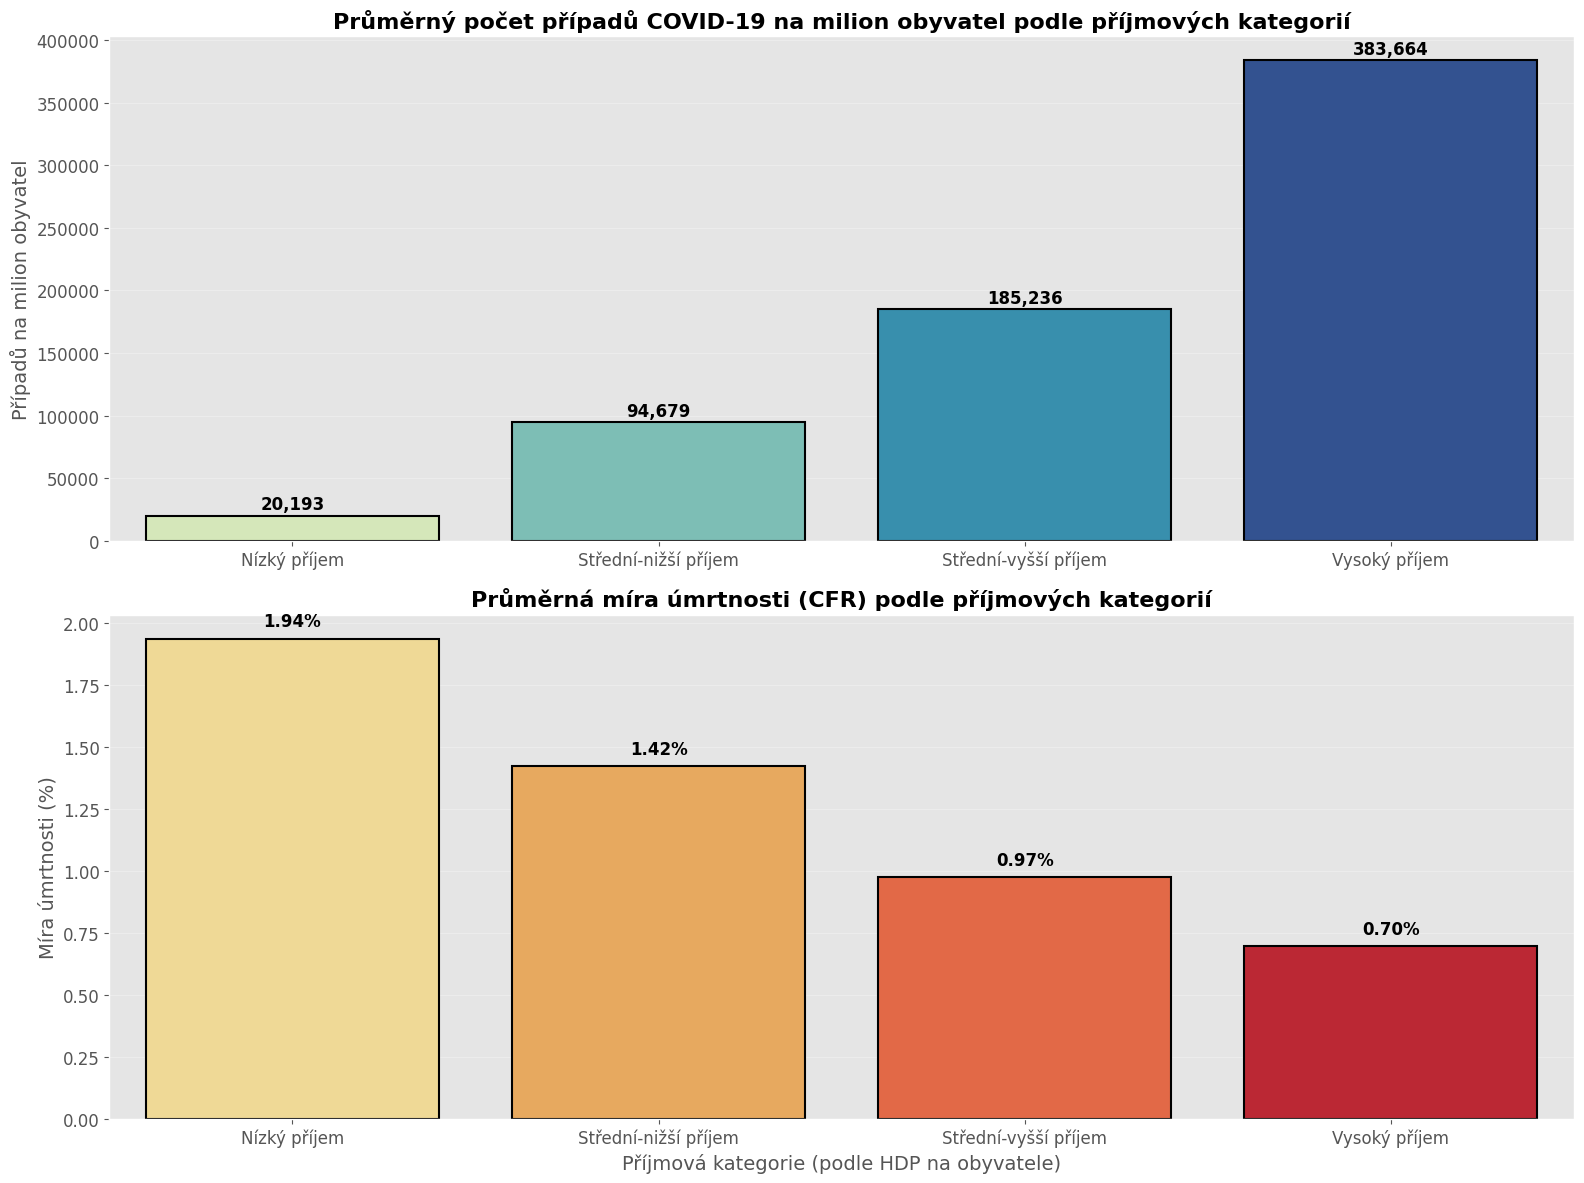


4.2 Analýza vlivu přijatých opatření

Průměrný počet nových případů a úmrtí podle přísnosti opatření:
  stringency_category  new_cases_per_million  new_deaths_per_million  country
0  Velmi nízká (0-25)             149.238263                0.419752    50169
1       Nízká (25-50)             212.043160                0.988253    65495
2     Střední (50-75)             146.355068                1.805365    55227
3     Vysoká (75-100)              93.835307                1.886134    23803


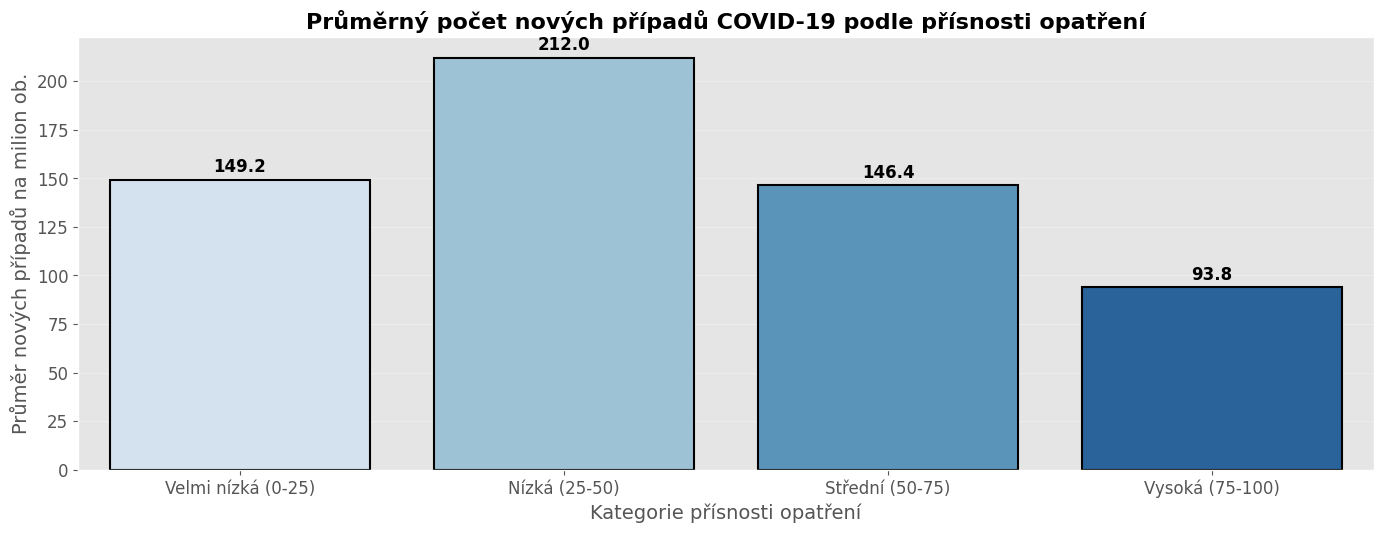

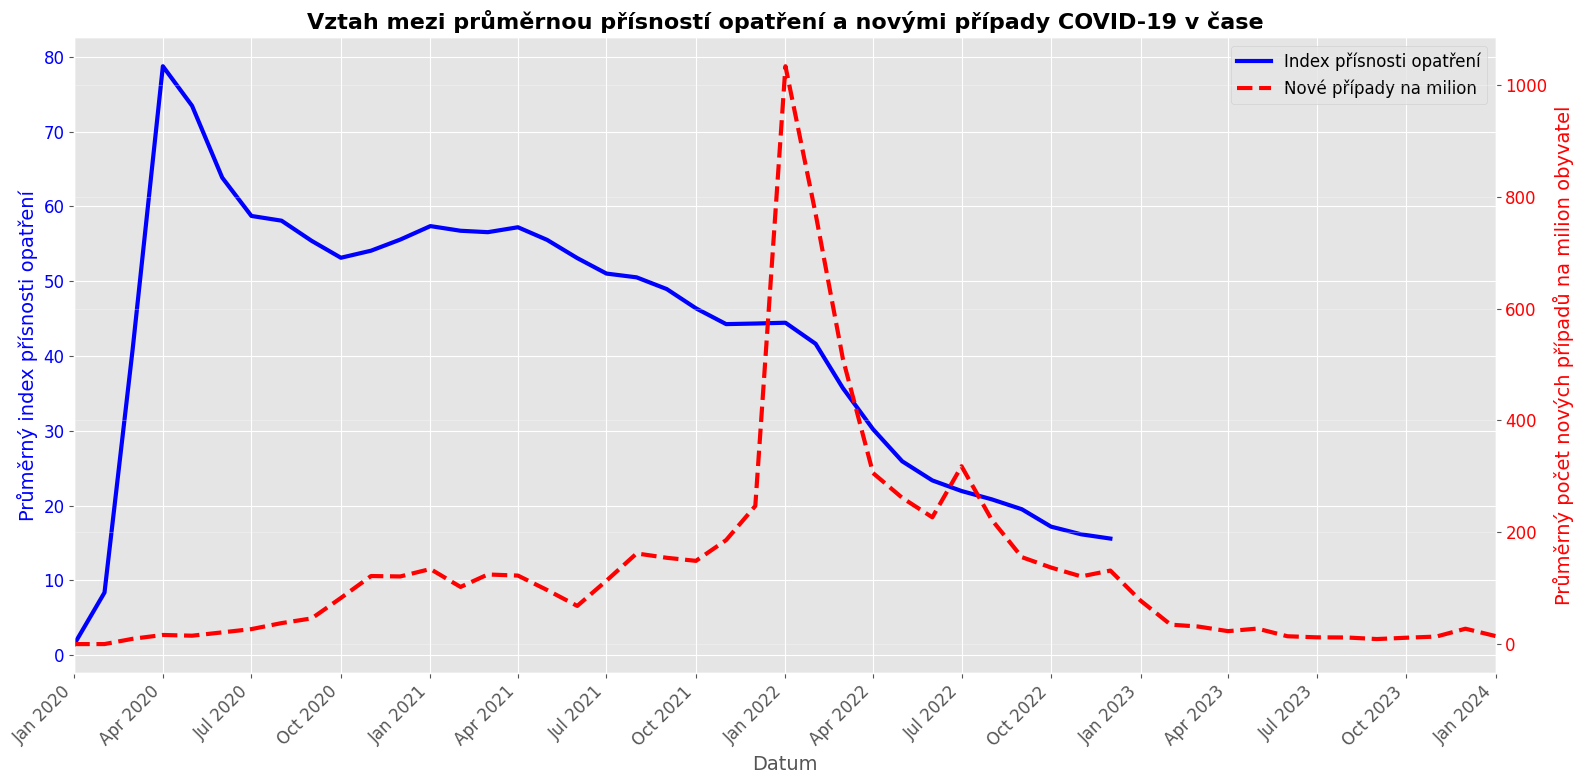


4.3 Analýza vlivu očkování

Dopad COVID-19 podle míry proočkovanosti:
  vaccination_category  total_cases_per_million  total_deaths_per_million  \
0     Nedostupné/0-20%             43463.436718                276.131195   
1               20-40%             65347.660238               1125.408021   
2               40-60%            148217.328279               1447.264529   
3               60-80%            266818.597636               1585.417865   
4              80-100%            296724.243576               1141.927828   

   case_fatality_rate  počet_zemí  
0            2.454197          20  
1            2.092451          37  
2            1.327616          52  
3            0.955771          77  
4            0.644484          40  


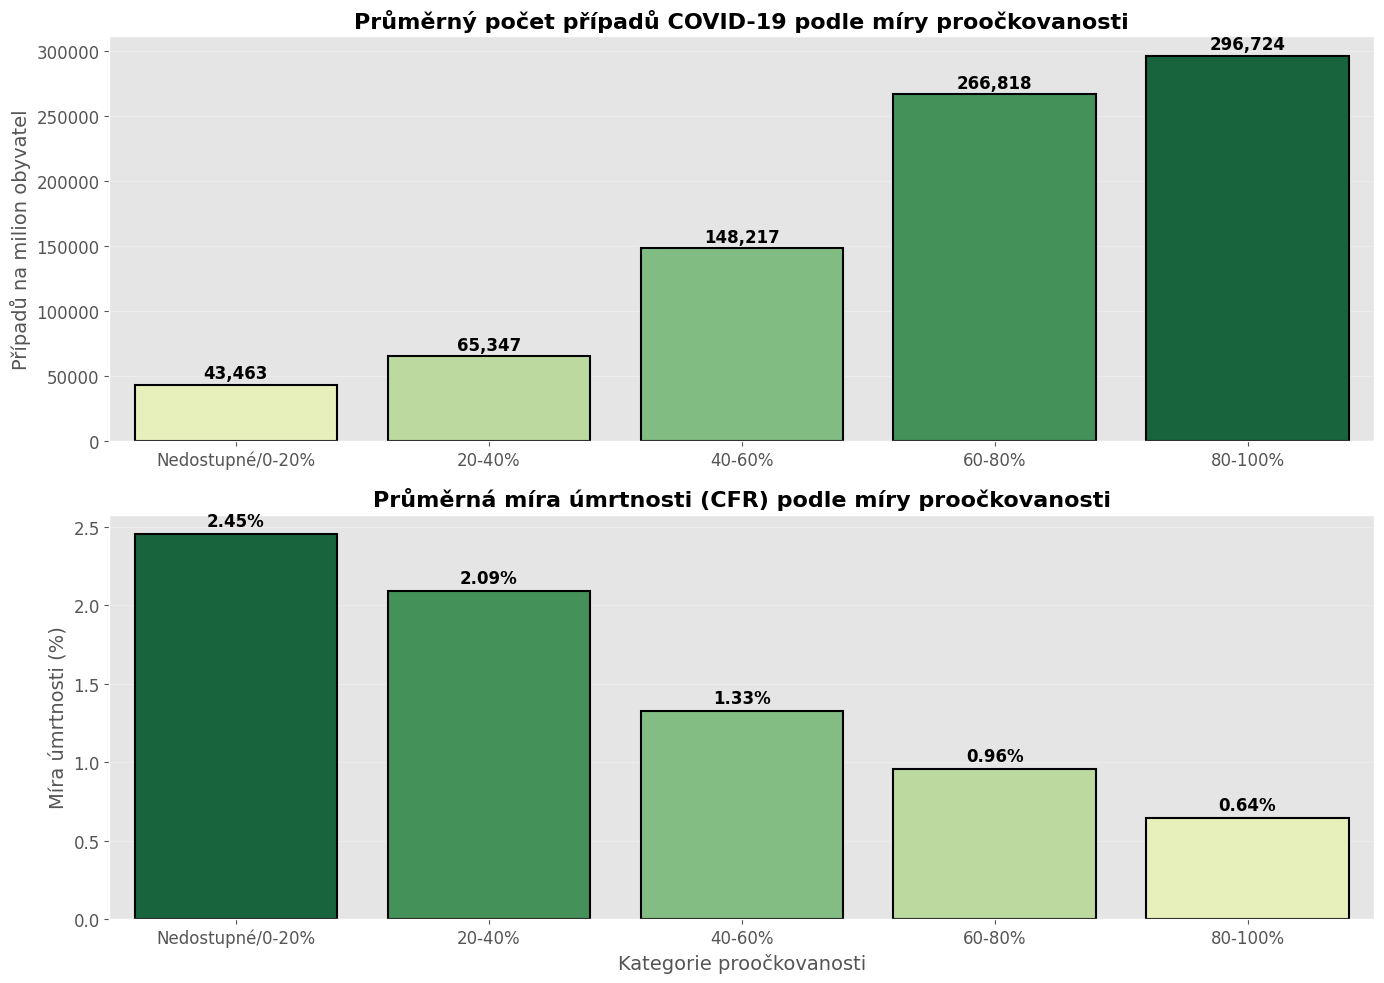

In [ ]:
# KAPITOLA 4: ANALÝZA ROZDÍLŮ DLE VYSPĚLOSTI, OPATŘENÍ A OČKOVÁNÍ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

print("## KAPITOLA 4: ANALÝZA ROZDÍLŮ DLE VYSPĚLOSTI, OPATŘENÍ A OČKOVÁNÍ ##")

# 4.1 Analýza podle příjmových skupin / ekonomické vyspělosti
print("\n4.1 Analýza podle příjmových skupin / ekonomické vyspělosti")

if 'gdp_per_capita' in df.columns and 'total_cases_per_million' in df.columns:

    # Vytvoření kategorií příjmů na základě HDP na obyvatele
    if 'gdp_per_capita' not in latest_by_country.columns:
        print("Sloupec 'gdp_per_capita' chybí v latest_by_country, ale je v df.")
        countries_gdp = df.dropna(subset=['gdp_per_capita']).sort_values('date').groupby('country').last()[['gdp_per_capita']]
        latest_by_country = latest_by_country.merge(countries_gdp, on='country', how='left')

    # Kategorizace zemí podle HDP
    latest_by_country['income_category'] = pd.cut(
        latest_by_country['gdp_per_capita'],
        bins=[0, 5000, 15000, 30000, 100000],
        labels=['Nízký příjem', 'Střední-nižší příjem', 'Střední-vyšší příjem', 'Vysoký příjem']
    )

    # Analýza podle příjmových skupin k poslednímu dostupnému datu
    income_group_analysis = latest_by_country.groupby('income_category').agg({
        'total_cases_per_million': 'mean',
        'total_deaths_per_million': 'mean',
        'country': 'count'
    }).reset_index()

    # Výpočet míry úmrtnosti po agregaci
    if 'total_deaths' in latest_by_country.columns and 'total_cases' in latest_by_country.columns:
        deaths_by_income = latest_by_country.groupby('income_category')['total_deaths'].sum()
        cases_by_income = latest_by_country.groupby('income_category')['total_cases'].sum()
        case_fatality = (deaths_by_income / cases_by_income.replace(0, np.nan) * 100)
        income_group_analysis['case_fatality_rate'] = case_fatality.values

    income_group_analysis = income_group_analysis.rename(columns={'country': 'počet_zemí'})

    print("\nDopad COVID-19 podle příjmových kategorií (založeno na HDP):")
    print(income_group_analysis)

    # Vizualizace dopadu podle příjmových skupin
    plt.figure(figsize=(16, 12))

    # Subplot 1: Případy na milion
    plt.subplot(2, 1, 1)
    bars = sns.barplot(x='income_category', y='total_cases_per_million', data=income_group_analysis,
                     palette='YlGnBu', edgecolor='black', linewidth=1.5)

    for i, v in enumerate(income_group_analysis['total_cases_per_million']):
        if not pd.isna(v):
            plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontweight='bold')

    plt.title('Průměrný počet případů COVID-19 na milion obyvatel podle příjmových kategorií', fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Případů na milion obyvatel')
    plt.grid(axis='y', alpha=0.3)

    # Subplot 2: Míra úmrtnosti
    plt.subplot(2, 1, 2)

    if 'case_fatality_rate' in income_group_analysis.columns:
        bars = sns.barplot(x='income_category', y='case_fatality_rate', data=income_group_analysis,
                        palette='YlOrRd', edgecolor='black', linewidth=1.5)

        for i, v in enumerate(income_group_analysis['case_fatality_rate']):
            if not pd.isna(v):
                plt.text(i, v + 0.05, f"{v:.2f}%", ha='center', fontweight='bold')

        plt.title('Průměrná míra úmrtnosti (CFR) podle příjmových kategorií', fontweight='bold')
    else:
        bars = sns.barplot(x='income_category', y='total_deaths_per_million', data=income_group_analysis,
                        palette='YlOrRd', edgecolor='black', linewidth=1.5)

        for i, v in enumerate(income_group_analysis['total_deaths_per_million']):
            if not pd.isna(v):
                plt.text(i, v + 50, f"{int(v):,}", ha='center', fontweight='bold')

        plt.title('Průměrný počet úmrtí na COVID-19 na milion obyvatel podle příjmových kategorií', fontweight='bold')

    plt.xlabel('Příjmová kategorie (podle HDP na obyvatele)')
    plt.ylabel('Míra úmrtnosti (%)' if 'case_fatality_rate' in income_group_analysis.columns else 'Úmrtí na milion obyvatel')
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Časový vývoj podle příjmových skupin
    gdp_categories = latest_by_country[['country', 'income_category']].dropna()
    df_with_income = df.merge(gdp_categories, on='country', how='left')

    # Agregace dat
    income_time_data = df_with_income.groupby(['date', 'income_category']).agg({
        'new_cases_per_million': 'mean',
        'new_deaths_per_million': 'mean'
    }).reset_index()

    # Vytváření klouzavých průměrů
    income_categories = income_time_data['income_category'].unique()

    for group in income_categories:
        if pd.isna(group):
            continue
        mask = income_time_data['income_category'] == group
        income_time_data.loc[mask, 'new_cases_smoothed'] = income_time_data.loc[mask, 'new_cases_per_million'].rolling(7).mean()

else:
    print("Chybí potřebná data pro analýzu podle příjmových skupin (gdp_per_capita nebo total_cases_per_million).")

# 4.2 Analýza vlivu přijatých opatření
print("\n4.2 Analýza vlivu přijatých opatření")

if 'stringency_index' in df.columns and 'new_cases_per_million' in df.columns:

    # Kategorizace přísnosti opatření
    df['stringency_category'] = pd.cut(
        df['stringency_index'],
        bins=[0, 25, 50, 75, 100],
        labels=['Velmi nízká (0-25)', 'Nízká (25-50)', 'Střední (50-75)', 'Vysoká (75-100)']
    )

    # Agregace dat podle kategorií přísnosti
    stringency_analysis = df.groupby('stringency_category').agg({
        'new_cases_per_million': 'mean',
        'new_deaths_per_million': 'mean',
        'country': 'count'
    }).reset_index()

    print("\nPrůměrný počet nových případů a úmrtí podle přísnosti opatření:")
    print(stringency_analysis)

    # Vizualizace vlivu přísnosti opatření
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 1, 1)
    bars = sns.barplot(x='stringency_category', y='new_cases_per_million', data=stringency_analysis,
                     palette='Blues', edgecolor='black', linewidth=1.5)

    for i, v in enumerate(stringency_analysis['new_cases_per_million']):
        plt.text(i, v + 4, f"{v:.1f}", ha='center', fontweight='bold')

    plt.title('Průměrný počet nových případů COVID-19 podle přísnosti opatření', fontweight='bold')
    plt.xlabel('Kategorie přísnosti opatření')
    plt.ylabel('Průměr nových případů na milion ob.')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Časová analýza přísnosti opatření a nových případů
    df['year_month'] = df['date'].dt.strftime('%Y-%m')

    monthly_stringency = df.groupby('year_month').agg({
        'stringency_index': 'mean',
        'new_cases_per_million': 'mean',
        'date': 'first'
    }).reset_index()

    # Seřazení podle data
    monthly_stringency = monthly_stringency.sort_values('date')

    # Vizualizace vztahu mezi přísností opatření a novými případy v čase
    fig, ax1 = plt.subplots(figsize=(16, 8))

    ax1.set_xlabel('Datum')
    ax1.set_ylabel('Průměrný index přísnosti opatření', color='blue')
    ax1.plot(monthly_stringency['date'], monthly_stringency['stringency_index'],
           color='blue', linewidth=3, label='Index přísnosti opatření')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Průměrný počet nových případů na milion obyvatel', color='red')
    ax2.plot(monthly_stringency['date'], monthly_stringency['new_cases_per_million'],
           color='red', linewidth=3, linestyle='--', label='Nové případy na milion')
    ax2.tick_params(axis='y', labelcolor='red')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title('Vztah mezi průměrnou přísností opatření a novými případy COVID-19 v čase', fontweight='bold')

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax1.set_xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2024-01-01"))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n4.3 Analýza vlivu očkování")

if 'people_fully_vaccinated_per_hundred' in latest_by_country.columns and 'total_cases_per_million' in latest_by_country.columns:

    # Kategorizace zemí podle míry proočkovanosti
    latest_by_country['vaccination_category'] = pd.cut(
        latest_by_country['people_fully_vaccinated_per_hundred'],
        bins=[-1, 20, 40, 60, 80, 100],
        labels=['Nedostupné/0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
    )

    # Agregace dat podle kategorií proočkovanosti
    vaccination_analysis = latest_by_country.groupby('vaccination_category').agg({
        'total_cases_per_million': 'mean',
        'total_deaths_per_million': 'mean',
        'case_fatality_rate': 'mean',
        'country': 'count'
    }).reset_index()

    vaccination_analysis = vaccination_analysis.rename(columns={'country': 'počet_zemí'})

    print("\nDopad COVID-19 podle míry proočkovanosti:")
    print(vaccination_analysis)

    # Vizualizace dopadu podle míry proočkovanosti
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 1, 1)
    bars = sns.barplot(x='vaccination_category', y='total_cases_per_million', data=vaccination_analysis,
                     palette='YlGn', edgecolor='black', linewidth=1.5)

    for i, v in enumerate(vaccination_analysis['total_cases_per_million']):
        plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontweight='bold')

    plt.title('Průměrný počet případů COVID-19 podle míry proočkovanosti', fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Případů na milion obyvatel')
    plt.grid(axis='y', alpha=0.3)

    plt.subplot(2, 1, 2)

    bars = sns.barplot(x='vaccination_category', y='case_fatality_rate', data=vaccination_analysis,
                     palette='YlGn_r', edgecolor='black', linewidth=1.5)

    for i, v in enumerate(vaccination_analysis['case_fatality_rate']):
        plt.text(i, v + 0.05, f"{v:.2f}%", ha='center', fontweight='bold')

    plt.title('Průměrná míra úmrtnosti (CFR) podle míry proočkovanosti', fontweight='bold')
    plt.xlabel('Kategorie proočkovanosti')
    plt.ylabel('Míra úmrtnosti (%)')
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

## 5. Analýza ekonomických dopadů

## KAPITOLA 5: ANALÝZA EKONOMICKÝCH DOPADŮ COVID-19 ##

HDP růst České republiky 2018-2024:
   year  gdp_growth              period
0  2018         3.6       Před pandemií
1  2019         2.8       Před pandemií
2  2020        -5.3  První rok pandemie
3  2021         4.0  Druhý rok pandemie
4  2022         2.8  Třetí rok pandemie
5  2023        -0.1  Postpandemický rok


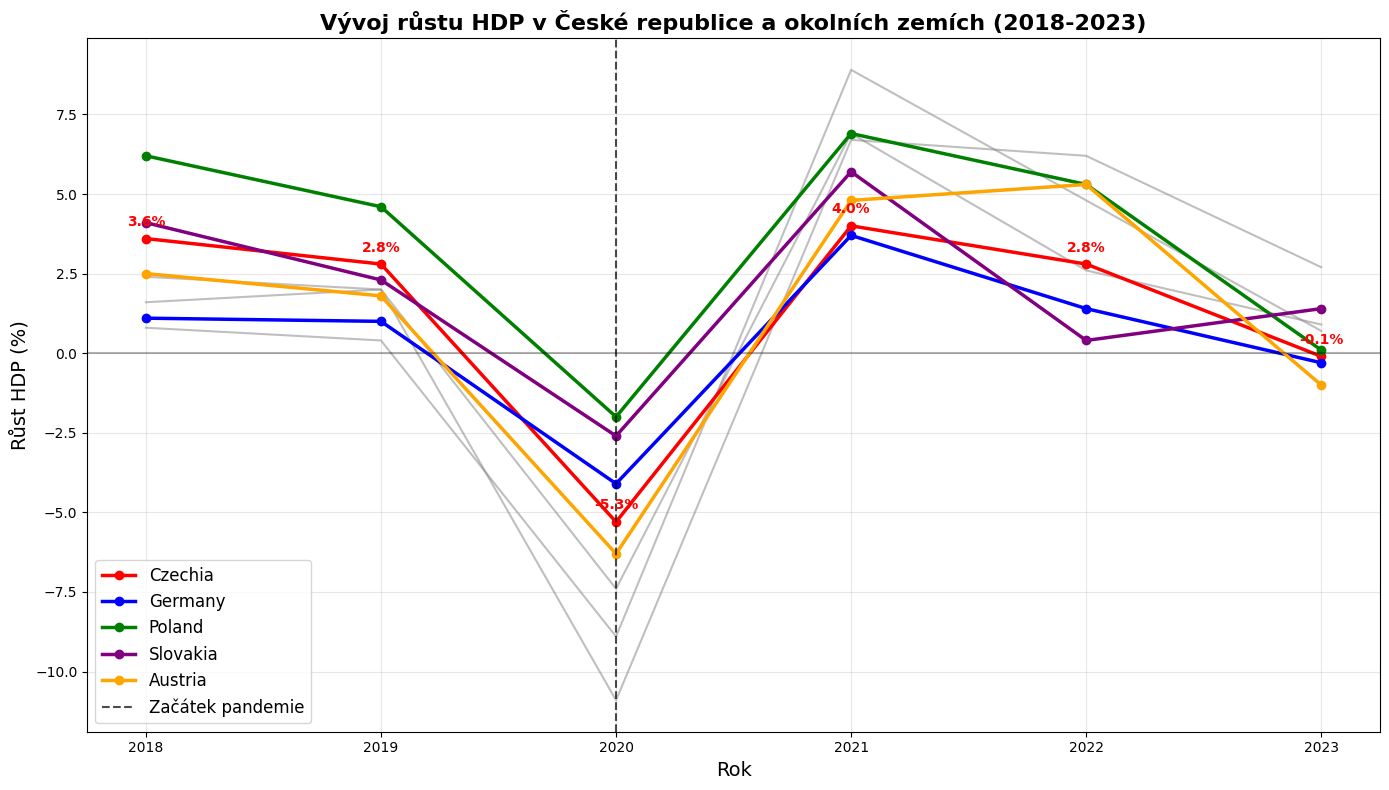

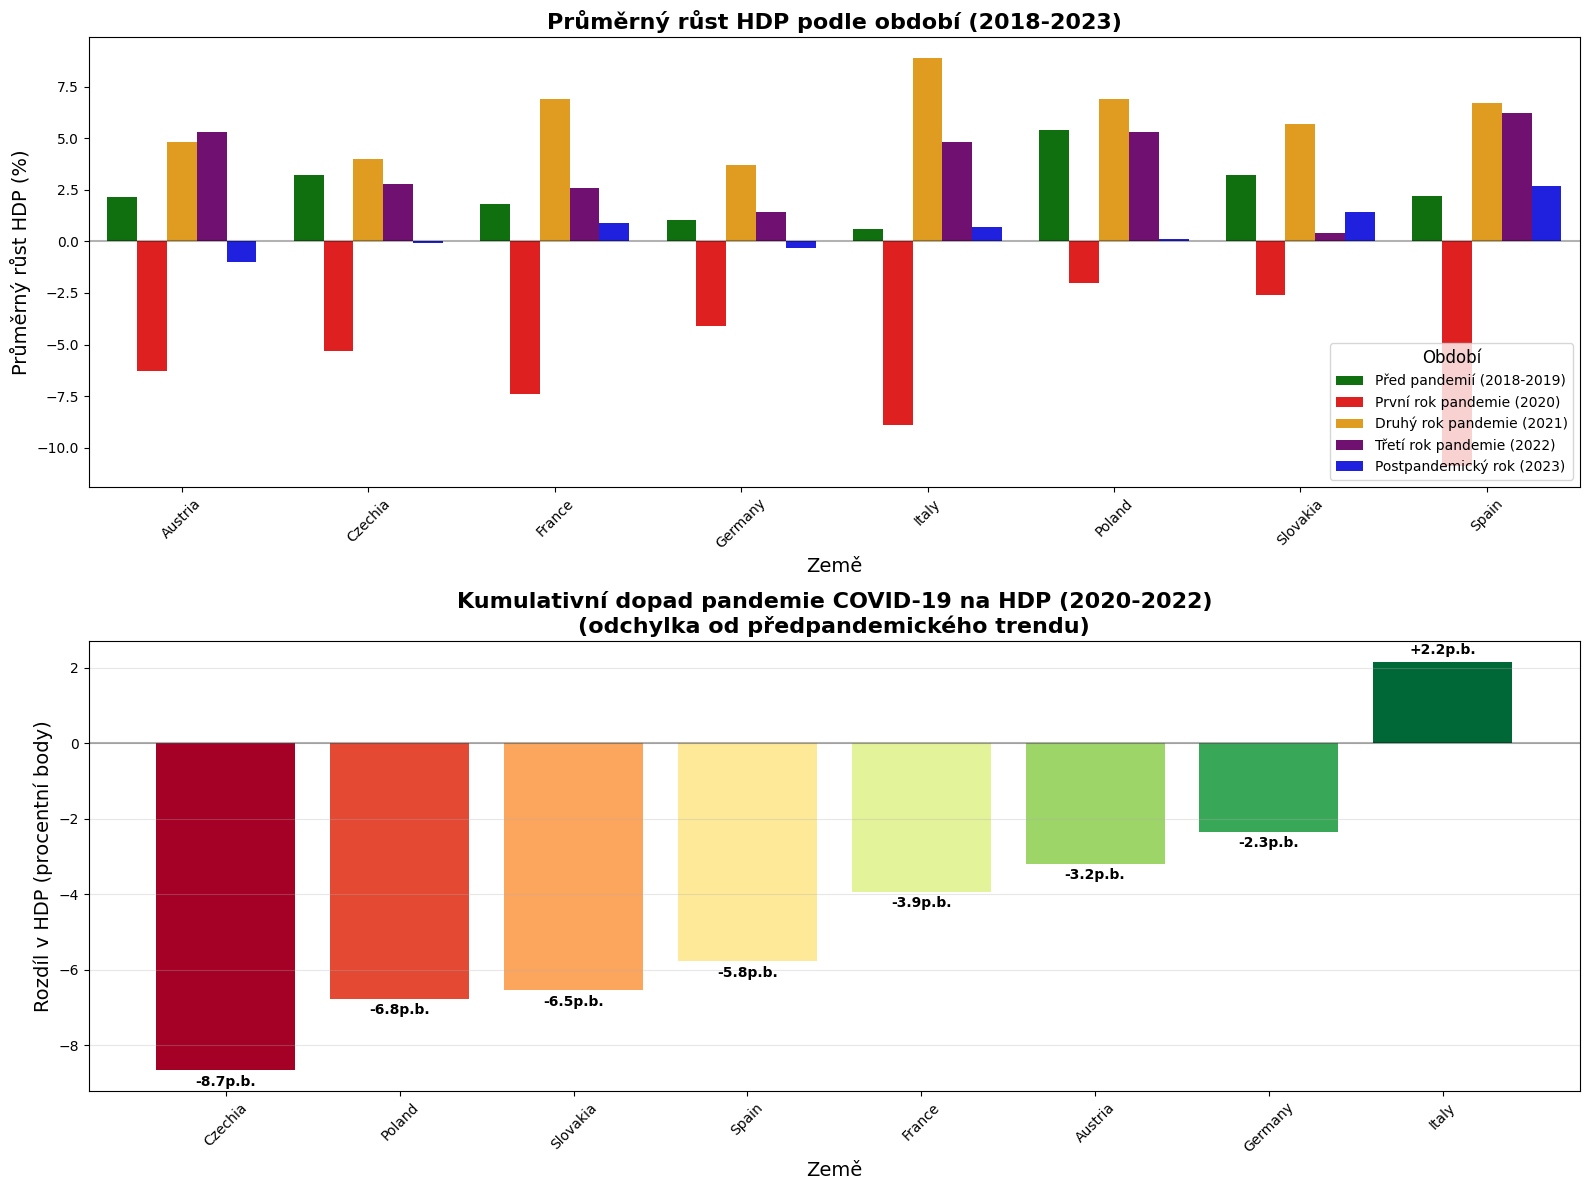

In [ ]:
# KAPITOLA 5: ANALÝZA EKONOMICKÝCH DOPADŮ COVID-19
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings

warnings.filterwarnings('ignore')

print("## KAPITOLA 5: ANALÝZA EKONOMICKÝCH DOPADŮ COVID-19 ##")

# Data o růstu HDP z Eurostatu pro období 2018-2023
gdp_growth_data = {
    # Formát: 'země': [2018, 2019, 2020, 2021, 2022, 2023]
    'Czechia': [3.6, 2.8, -5.3, 4.0, 2.8, -0.1],
    'Germany': [1.1, 1.0, -4.1, 3.7, 1.4, -0.3],
    'France': [1.6, 2.0, -7.4, 6.9, 2.6, 0.9],
    'Italy': [0.8, 0.4, -8.9, 8.9, 4.8, 0.7],
    'Spain': [2.4, 2.0, -10.9, 6.7, 6.2, 2.7],
    'Poland': [6.2, 4.6, -2.0, 6.9, 5.3, 0.1],
    'Slovakia': [4.1, 2.3, -2.6, 5.7, 0.4, 1.4],
    'Austria': [2.5, 1.8, -6.3, 4.8, 5.3, -1.0]
}

# Roky pro analýzu
years = [2018, 2019, 2020, 2021, 2022, 2023]

# Vytvoření DataFrame
gdp_df = pd.DataFrame(columns=['country', 'year', 'gdp_growth', 'period'])

for country, growth_values in gdp_growth_data.items():
    for i, year in enumerate(years):
        if year < 2020:
            period = 'Před pandemií'
        elif year == 2020:
            period = 'První rok pandemie'
        elif year == 2021:
            period = 'Druhý rok pandemie'
        elif year == 2022:
            period = 'Třetí rok pandemie'
        else:
            period = 'Postpandemický rok'

        gdp_df = pd.concat([gdp_df, pd.DataFrame({
            'country': [country],
            'year': [year],
            'gdp_growth': [growth_values[i]],
            'period': [period]
        })], ignore_index=True)

# Zobrazení statistik HDP pro Českou republiku
czech_gdp = gdp_df[gdp_df['country'] == 'Czechia']
print("\nHDP růst České republiky 2018-2024:")
print(czech_gdp[['year', 'gdp_growth', 'period']])

# Vizualizace HDP pro vybrané země se zdůrazněním České republiky
plt.figure(figsize=(14, 8))

for country in gdp_growth_data.keys():
    if country != 'Czechia':
        country_data = gdp_df[gdp_df['country'] == country]
        plt.plot(country_data['year'], country_data['gdp_growth'],
                 color='gray', alpha=0.5, linewidth=1.5, label='_nolegend_')

for country, color in [('Czechia', 'red'), ('Germany', 'blue'),
                       ('Poland', 'green'), ('Slovakia', 'purple'),
                       ('Austria', 'orange')]:
    country_data = gdp_df[gdp_df['country'] == country]
    plt.plot(country_data['year'], country_data['gdp_growth'],
             color=color, linewidth=2.5, marker='o', markersize=6, label=country)

plt.axvline(x=2020, color='black', linestyle='--', alpha=0.7, label='Začátek pandemie')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.title('Vývoj růstu HDP v České republice a okolních zemích (2018-2023)',
         fontsize=16, fontweight='bold')
plt.xlabel('Rok', fontsize=14)
plt.ylabel('Růst HDP (%)', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(years)

for i, row in czech_gdp.iterrows():
    value = row['gdp_growth']
    plt.text(row['year'], value + 0.3, f"{value:.1f}%",
             ha='center', va='bottom', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

# Porovnání růstu HDP všech zemí před, během a po pandemii
plt.figure(figsize=(16, 12))

# Příprava dat pro barplot
summary_data = gdp_df.copy()
summary_data['period_numeric'] = summary_data['year'].apply(
    lambda x: 0 if x < 2020 else (1 if x == 2020 else (2 if x == 2021 else (3 if x == 2022 else 4)))
)

# Průměrný růst HDP podle období
avg_growth = summary_data.groupby(['country', 'period_numeric']).agg({
    'gdp_growth': 'mean'
}).reset_index()

# Období
avg_growth['period'] = avg_growth['period_numeric'].map({
    0: 'Před pandemií (2018-2019)',
    1: 'První rok pandemie (2020)',
    2: 'Druhý rok pandemie (2021)',
    3: 'Třetí rok pandemie (2022)',
    4: 'Postpandemický rok (2023)'
})

# Barplot průměrného růstu HDP podle období
plt.subplot(2, 1, 1)
sns.barplot(x='country', y='gdp_growth', hue='period',
          data=avg_growth, palette=['green', 'red', 'orange', 'purple', 'blue'])

plt.title('Průměrný růst HDP podle období (2018-2023)', fontsize=16, fontweight='bold')
plt.xlabel('Země', fontsize=14)
plt.ylabel('Průměrný růst HDP (%)', fontsize=14)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)
plt.legend(title='Období', fontsize=10, title_fontsize=12)

# Výpočet kumulativního vlivu pandemie na velikost HDP
impact_data = []
for country in gdp_growth_data.keys():
    pre_pandemic_growth = gdp_df[(gdp_df['country'] == country) &
                               (gdp_df['year'] < 2020)]['gdp_growth'].mean()

    actual_values = gdp_df[(gdp_df['country'] == country) &
                          (gdp_df['year'].between(2020, 2022))]['gdp_growth'].tolist()

    # Výpočet kumulativního růstu (skutečnost)
    actual_cumulative = (1 + actual_values[0]/100) * (1 + actual_values[1]/100) * (1 + actual_values[2]/100) - 1

    # Výpočet hypotetického růstu bez pandemie
    hypothetical_cumulative = (1 + pre_pandemic_growth/100) ** 3 - 1

    # Rozdíl v procentních bodech (dopad pandemie)
    impact = (actual_cumulative - hypothetical_cumulative) * 100

    impact_data.append({
        'country': country,
        'impact': impact
    })

impact_df = pd.DataFrame(impact_data)
impact_df = impact_df.sort_values('impact')

# Barplot kumulativního dopadu
plt.subplot(2, 1, 2)
bars = plt.bar(impact_df['country'], impact_df['impact'],
             color=plt.cm.RdYlGn(np.linspace(0, 1, len(impact_df))))

plt.title('Kumulativní dopad pandemie COVID-19 na HDP (2020-2022)\n(odchylka od předpandemického trendu)',
         fontsize=16, fontweight='bold')
plt.xlabel('Země', fontsize=14)
plt.ylabel('Rozdíl v HDP (procentní body)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

for i, v in enumerate(impact_df['impact']):
    if v < 0:
        plt.text(i, v - 0.12, f"{v:.1f}p.b.", ha='center', va='top', fontweight='bold')
    else:
        plt.text(i, v + 0.12, f"+{v:.1f}p.b.", ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 6. Predikce modelem Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbq4hjgw/tmy_us5i.json



## PREDIKCE šíření COVID-19 Prophet modelem


DEBUG:cmdstanpy:input tempfile: /tmp/tmphbq4hjgw/ur32gzro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23951', 'data', 'file=/tmp/tmphbq4hjgw/tmy_us5i.json', 'init=/tmp/tmphbq4hjgw/ur32gzro.json', 'output', 'file=/tmp/tmphbq4hjgw/prophet_model4uab34fy/prophet_model-20250327111110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:11:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:11:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


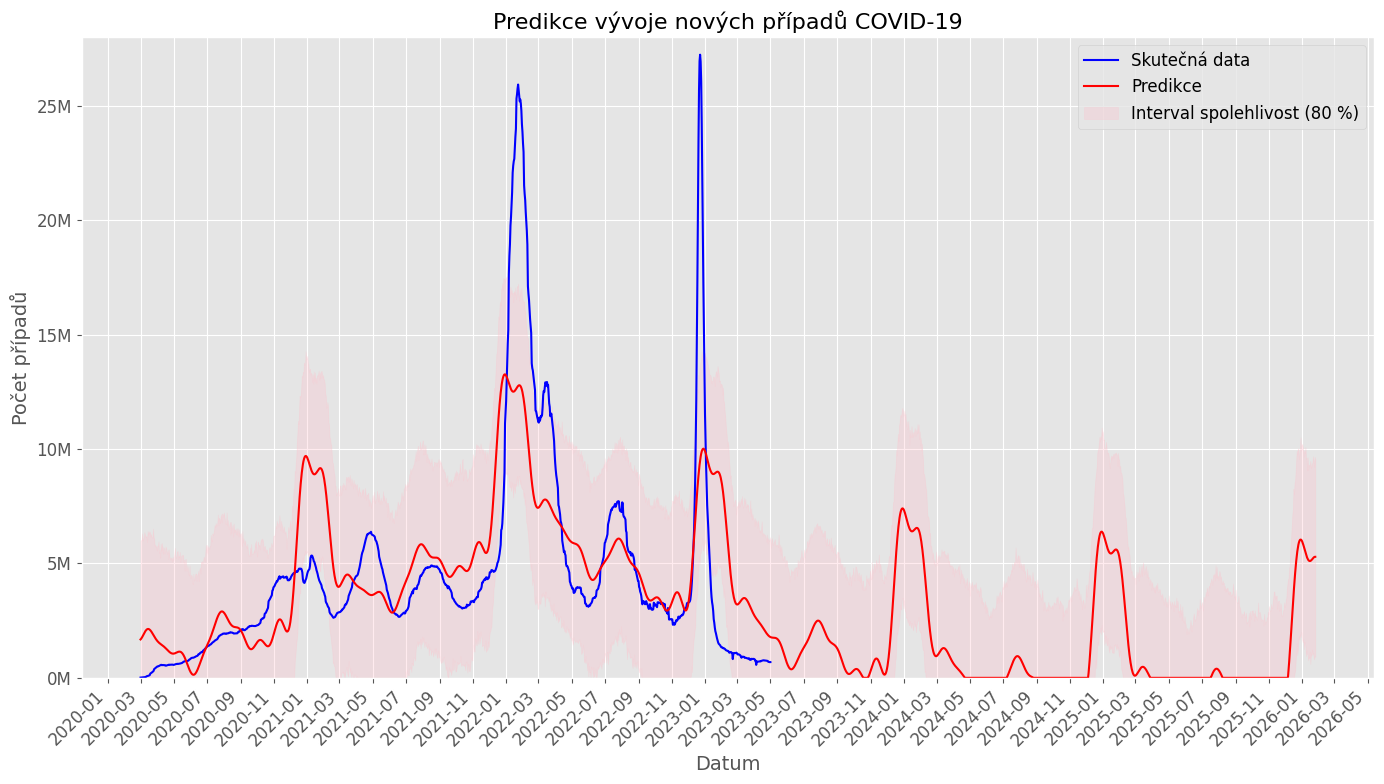

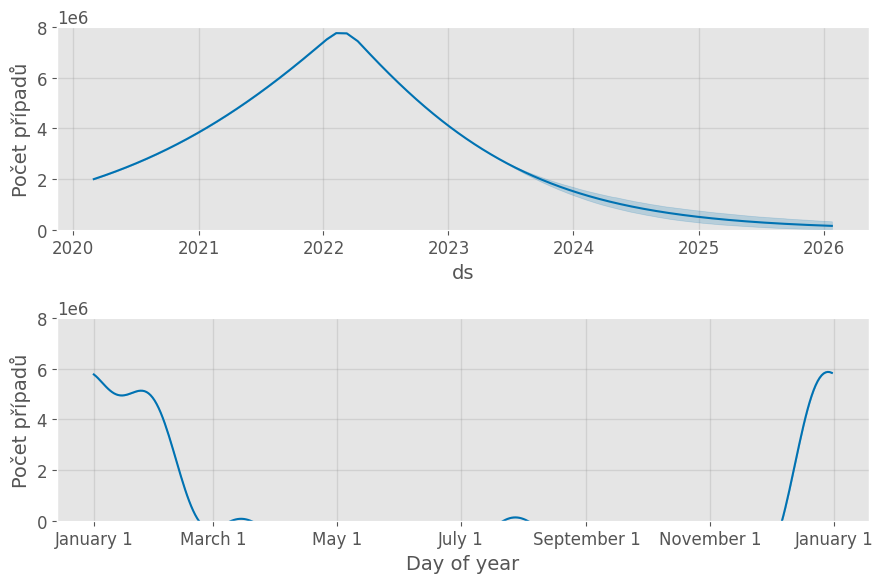

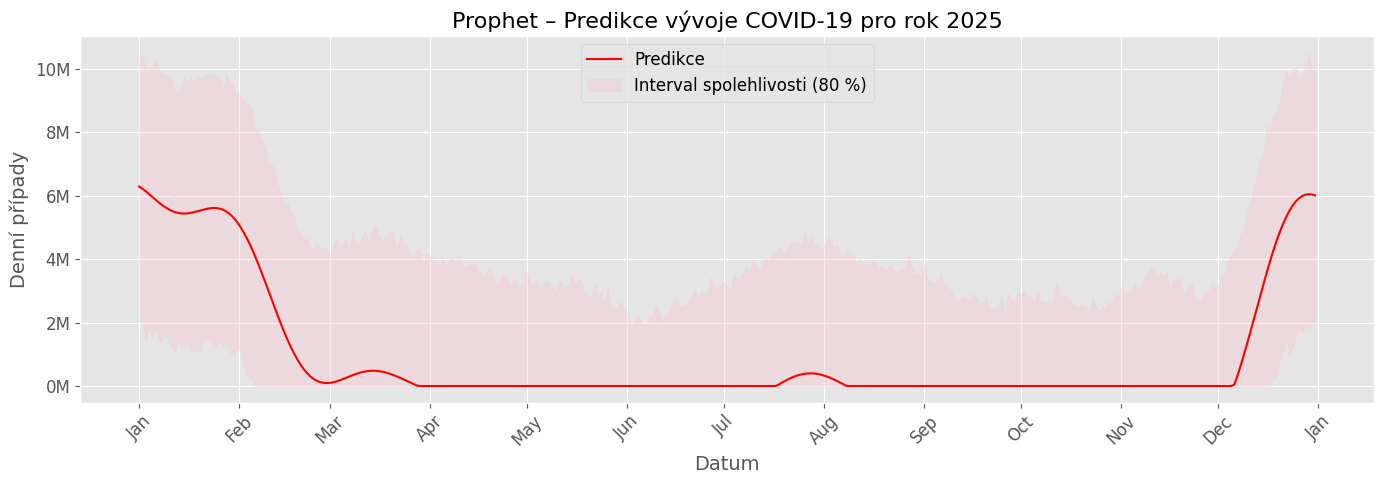

In [ ]:
# 6. Predikce modelem Prophet
from prophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

print("\n## PREDIKCE šíření COVID-19 Prophet modelem")

# 1. Příprava dat před modelováním
df_daily = (
    df_clean.groupby('date')['new_cases'].sum().reset_index()
    .rename(columns={'date': 'ds', 'new_cases': 'y'})
)
df_daily['y'] = df_daily['y'].rolling(window=7, center=True, min_periods=1).mean()

# 2. Tréninková data a omezení
df_train = df_daily[(df_daily['ds'] >= '2020-03-01') & (df_daily['ds'] <= '2023-05-01')].copy()
df_train['cap'] = 20_000_000

# 3. Nastavení hyperparametrů modelu
model = Prophet(
    growth='logistic',
    changepoint_prior_scale=0.05,
    n_changepoints=30,
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=False,
)
model.fit(df_train)

# 4. Predikce budoucího šíření
future = model.make_future_dataframe(periods=1000)
future['cap'] = 20_000_000
forecast = model.predict(future)
forecast[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']].clip(lower=0)

# 5. Vykreslení hlavního grafu
plt.figure(figsize=(14, 8))
plt.plot(df_train['ds'], df_train['y'], label='Skutečná data', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predikce', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3, label='Interval spolehlivost (80 %)')
plt.title("Predikce vývoje nových případů COVID-19")
plt.xlabel("Datum"), plt.ylabel("Počet případů")
plt.ylim(0, 28_000_000)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.grid(True), plt.legend(), plt.tight_layout()
plt.show()

# 6. Trend šíření + roční sezónnost
fig2 = model.plot_components(forecast)
axes = fig2.get_axes()
for ax in axes:
    ax.set_ylabel("Počet případů")
    ax.set_ylim(0, 8_000_000)
plt.tight_layout()
plt.show()

#Graf predikce
start_2025 = pd.to_datetime("2025-01-01")
end_2026 = pd.to_datetime("2026-01-01")

forecast_2025 = forecast[(forecast['ds'] >= start_2025) & (forecast['ds'] < end_2026)]

plt.figure(figsize=(14, 5))
plt.plot(forecast_2025['ds'], forecast_2025['yhat'], label='Predikce', color='red')
plt.fill_between(forecast_2025['ds'], forecast_2025['yhat_lower'], forecast_2025['yhat_upper'],
                 color='pink', alpha=0.3, label='Interval spolehlivosti (80 %)')
plt.title("Prophet – Predikce vývoje COVID-19 pro rok 2025")
plt.xlabel("Datum")
plt.ylabel("Denní případy")
plt.grid(True)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Predikce modelem XGBoost

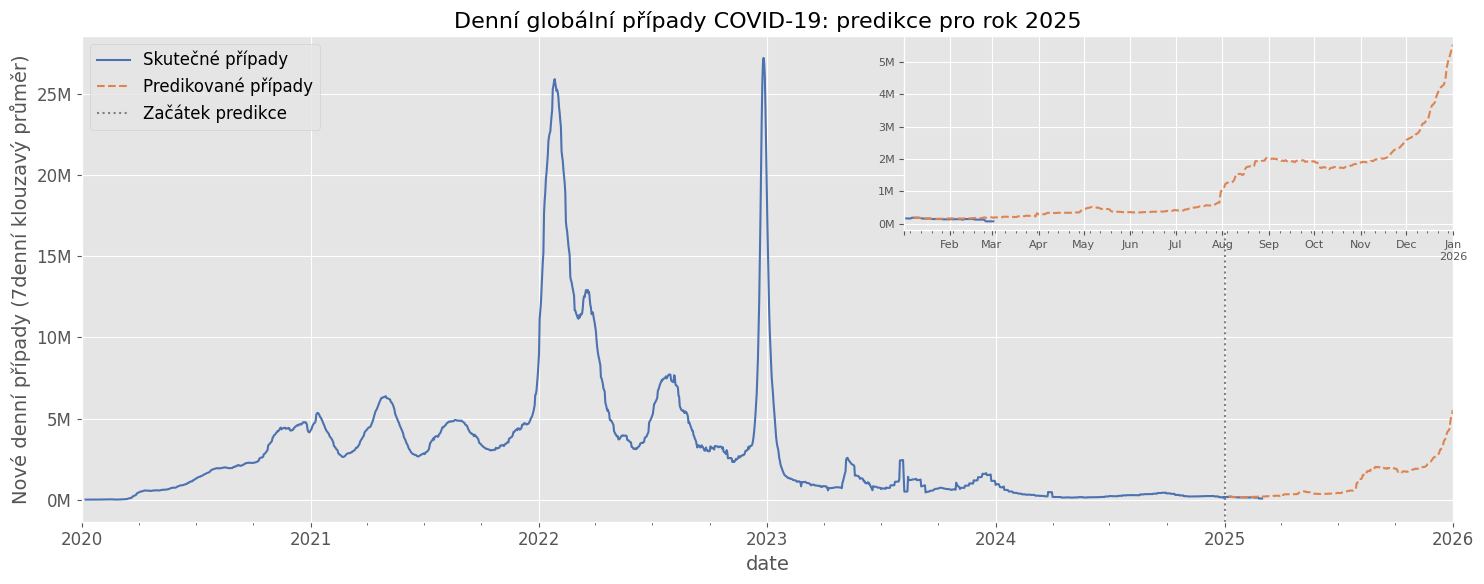

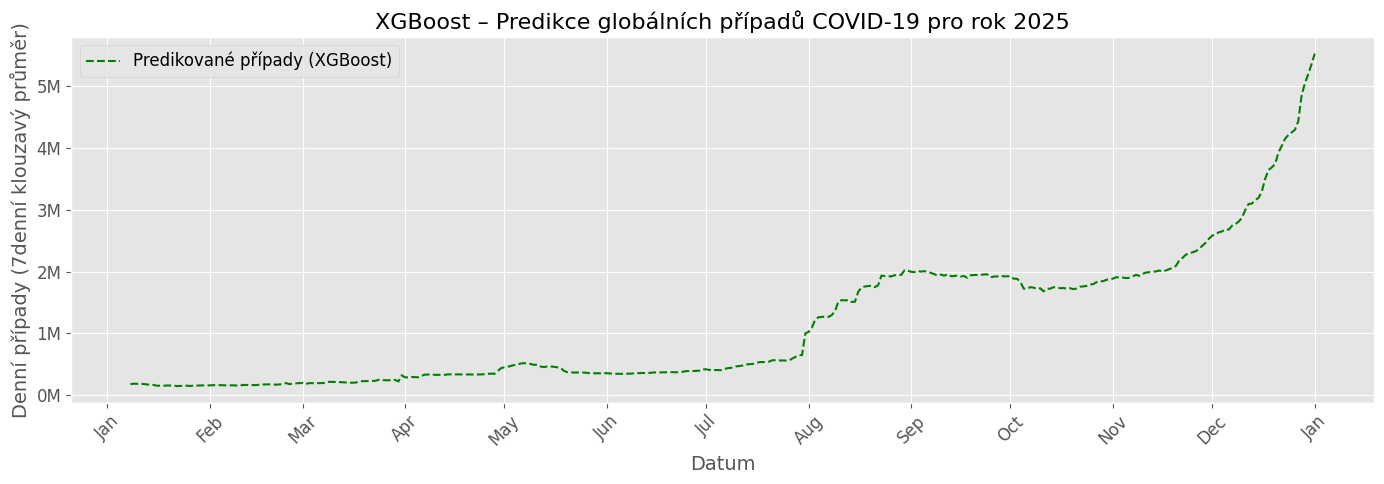

In [ ]:
# 7. Predikce modelem XGBoost
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. Příprava denních dat
df_global = df.groupby('date')['new_cases'].sum().reset_index()

# Zesílení podhodnocených hodnot po konci pandemie (Květen 2023)
cutoff_date = pd.to_datetime("2023-05-01")
df_global.loc[df_global['date'] >= cutoff_date, 'new_cases'] *= 4

# Přejmenování sloupců
df_daily = df_global.rename(columns={'new_cases': 'daily_cases'})

# 2. Inženýrství příznaků
def create_daily_features(df, lags=7, roll_windows=[3, 7], fourier_order=3):
    df = df.copy()
    df = df.sort_values('date').reset_index(drop=True)

    # Kalendářové příznaky
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear

    # Zpožděné hodnoty (lag features)
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['daily_cases'].shift(lag)

    # Klouzavé průměry
    for window in roll_windows:
        df[f'roll_mean_{window}'] = df['daily_cases'].shift(1).rolling(window=window).mean()

    # Hodnota ze stejného dne před rokem
    df['lag_365'] = df['daily_cases'].shift(365)

    # Fourierovy členy pro sezónnost (roční cyklus)
    df = df.set_index('date')
    for k in range(1, fourier_order + 1):
        df[f'sin_{k}'] = np.sin(2 * np.pi * k * np.arange(len(df)) / 365)
        df[f'cos_{k}'] = np.cos(2 * np.pi * k * np.arange(len(df)) / 365)
    df = df.reset_index()

    return df.dropna().reset_index(drop=True)

df_features = create_daily_features(df_daily)

# 3. Trénování modelu (do 1. 1.2025)
forecast_start_date = pd.to_datetime("2025-01-02")
train = df_features[df_features['date'] < forecast_start_date]

features = [col for col in train.columns if col not in ['date', 'daily_cases']]
X_train, y_train = train[features], train['daily_cases']

model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=10)
model.fit(X_train, y_train)

# 4. Rekurzivní predikce (365 dní od 2.1.2025)
forecast_days = 365
history = df_features[df_features['date'] < forecast_start_date].copy()
future_dates = []
future_preds = []

for i in range(forecast_days):
    last_row = history.iloc[-1:].copy()
    next_date = pd.Timestamp(last_row['date'].values[0]) + pd.Timedelta(days=1)
    future_dates.append(next_date)

    new_row = {
        'date': next_date,
        'dayofweek': next_date.dayofweek,
        'month': next_date.month,
        'dayofyear': next_date.dayofyear,
    }

    # Zpožděné hodnoty
    for lag in range(1, 8):
        new_row[f'lag_{lag}'] = history['daily_cases'].iloc[-lag]

    # Klouzavé průměry
    for window in [3, 7]:
        new_row[f'roll_mean_{window}'] = history['daily_cases'].iloc[-window:].mean()

    # Hodnota před rokem (pokud je dostupná)
    if len(history) >= 365:
        new_row['lag_365'] = history['daily_cases'].iloc[-365]
    else:
        new_row['lag_365'] = history['daily_cases'].mean()

    # Fourierovy členy
    t = len(history)
    for k in range(1, 4):
        new_row[f'sin_{k}'] = np.sin(2 * np.pi * k * t / 365)
        new_row[f'cos_{k}'] = np.cos(2 * np.pi * k * t / 365)

    input_df = pd.DataFrame([new_row])
    pred = model.predict(input_df[features])[0]
    new_row['daily_cases'] = pred
    future_preds.append(pred)

    history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)

# 5. Vykreslení predikce (7denní klouzavý průměr)
forecast_df = pd.DataFrame({
    'date': future_dates,
    'forecasted_cases': future_preds
}).set_index('date')

# Spojení skutečných a predikovaných dat
plot_df = df_daily.set_index('date')[['daily_cases']].join(forecast_df, how='outer')

# Výpočet 7denního klouzavého průměru
plot_df['daily_cases_ma7'] = plot_df['daily_cases'].rolling(window=7).mean()
plot_df['forecasted_cases_ma7'] = plot_df['forecasted_cases'].rolling(window=7).mean()

from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Hlavní graf
fig, ax = plt.subplots(figsize=(15, 6))
plot_df['daily_cases_ma7'].plot(ax=ax, label='Skutečné případy')
plot_df['forecasted_cases_ma7'].plot(ax=ax, label='Predikované případy', linestyle='--')
ax.axvline(x=forecast_start_date, color='gray', linestyle=':', label='Začátek predikce')
ax.set_title('Denní globální případy COVID-19: predikce pro rok 2025')
ax.set_ylabel('Nové denní případy (7denní klouzavý průměr)')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
ax.legend()
ax.grid(True)

# Výřezový graf
axins = inset_axes(ax, width="40%", height="40%", loc='upper right', borderpad=0)

zoom_df = plot_df[plot_df.index >= forecast_start_date]

zoom_df['daily_cases_ma7'].plot(ax=axins, label='Skutečné', color='C0')
zoom_df['forecasted_cases_ma7'].plot(ax=axins, label='Predikované', linestyle='--', color='C1')
axins.set_ylabel('')
axins.set_xlabel('')
axins.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
axins.grid(True)
axins.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

# Graf predikce
start = pd.to_datetime("2025-01-01")
end = pd.to_datetime("2026-01-01")

xgb_pred_slice = forecast_df.loc[start:end].copy()
xgb_pred_slice['forecasted_cases_ma7'] = xgb_pred_slice['forecasted_cases'].rolling(7).mean()

plt.figure(figsize=(14, 5))
plt.plot(xgb_pred_slice.index, xgb_pred_slice['forecasted_cases_ma7'],
         label='Predikované případy (XGBoost)', color='green', linestyle='--')

plt.title("XGBoost – Predikce globálních případů COVID-19 pro rok 2025")
plt.xlabel("Datum")
plt.ylabel("Denní případy (7denní klouzavý průměr)")
plt.grid(True)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 8. Predikce modelem LSMT neuronové sítě

X: (1209, 365, 12), y: (1209, 365)
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0474 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0308 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0216 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0154 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0125 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0109 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0102 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0095 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0084 - val_loss: 0.0032

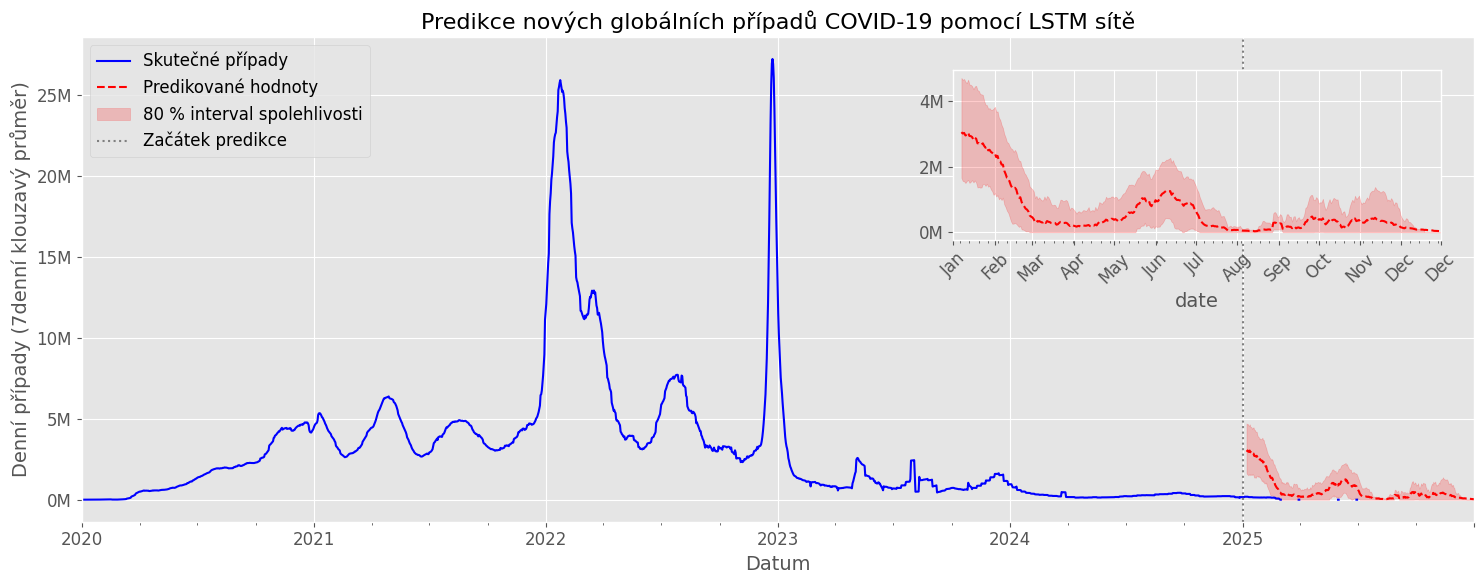

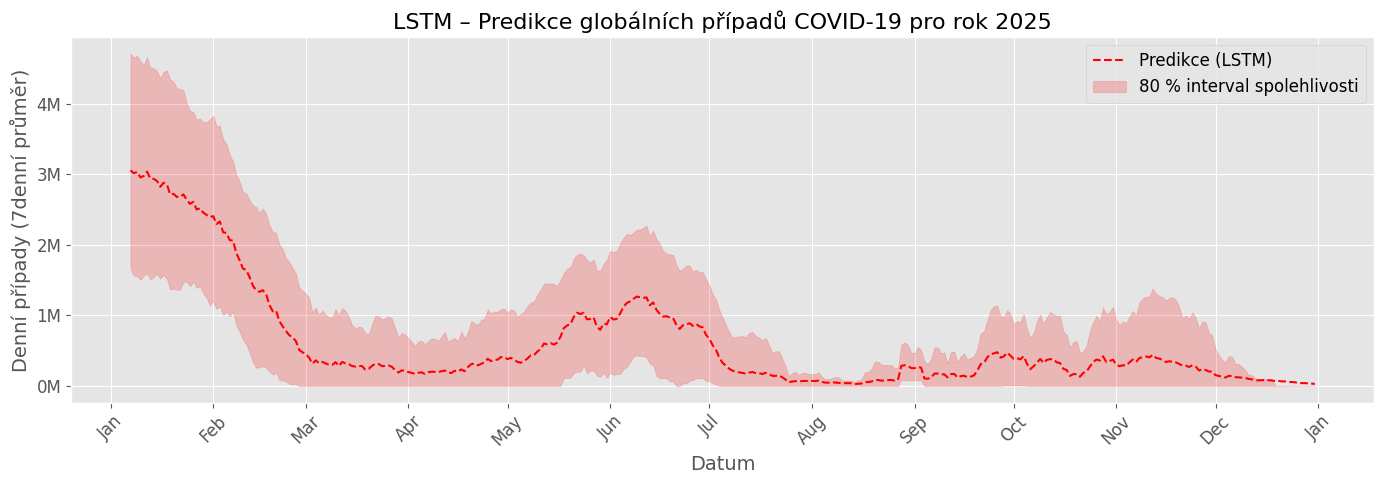

In [ ]:
#8. Predikce modelem LSMT neuronové sítě
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Conv1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import dates as mdates

# 1. Příprava dat
df = df[(df['date'] >= '2021-01-01') & (df['date'] <= '2022-12-31')].copy()
df = df_clean.groupby('date')['new_cases'].sum().reset_index()
df.loc[df['date'] >= '2023-05-01', 'new_cases'] *= 4
df['cases_7d'] = df['new_cases'].rolling(7, center=True, min_periods=1).mean()

# Sezónní a dynamické příznaky
df['dayofyear'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month

# Fourier složky
df['sin1'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['cos1'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
df['sin2'] = np.sin(4 * np.pi * df['dayofyear'] / 365)
df['cos2'] = np.cos(4 * np.pi * df['dayofyear'] / 365)
df['sin3'] = np.sin(6 * np.pi * df['dayofyear'] / 365)
df['cos3'] = np.cos(6 * np.pi * df['dayofyear'] / 365)

# Trend/dynamika
df['delta'] = df['cases_7d'].diff().fillna(0)
df['pct_change'] = df['cases_7d'].pct_change().fillna(0)
df['roll7'] = df['cases_7d'].rolling(7).mean().fillna(0)
df['roll30'] = df['cases_7d'].rolling(30).mean().fillna(0)

# Feature výběr
features = ['cases_7d', 'delta', 'pct_change', 'roll7', 'roll30',
            'sin1', 'cos1', 'sin2', 'cos2', 'sin3', 'cos3', 'month']
df = df.dropna().reset_index(drop=True)

# Škálování
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features] = scaler_X.fit_transform(df[features])
df_scaled['cases_7d_scaled'] = scaler_y.fit_transform(df[['cases_7d']])

# 2. Sekvence
window_size = 365
horizon = 365
X, y = [], []

for i in range(window_size, len(df_scaled) - horizon):
    seq_x = df_scaled.loc[i - window_size:i - 1, features].values
    seq_y = df_scaled.loc[i:i + horizon - 1, 'cases_7d_scaled'].values
    if len(seq_y) == horizon:
        X.append(seq_x)
        y.append(seq_y)

X = np.array(X)
y = np.array(y)
print(f"X: {X.shape}, y: {y.shape}")

# 3. Trénování modelu
class MCDropout(Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

input_layer = Input(shape=(window_size, len(features)))
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = LSTM(64, return_sequences=True)(x)
x = MCDropout(0.3)(x)
x = LSTM(32)(x)
x = MCDropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(horizon, activation='relu')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')

callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True),
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=1)
]

model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=1)

# 4. Predikce
forecast_start = pd.to_datetime("2025-01-01")
idx = df_scaled[df_scaled['date'] == forecast_start].index[0]
X_input = df_scaled.loc[idx - window_size:idx - 1, features].values.reshape(1, window_size, len(features))

mc_runs = 100
mc_predictions = []

for _ in range(mc_runs):
    pred = model(X_input, training=True).numpy()[0]
    pred = scaler_y.inverse_transform(pred.reshape(-1, 1)).flatten()
    pred = np.maximum(pred, 0)
    mc_predictions.append(pred)

mc_predictions = np.array(mc_predictions)
mean_pred = mc_predictions.mean(axis=0)
lower_bound = np.percentile(mc_predictions, 10, axis=0)
upper_bound = np.percentile(mc_predictions, 90, axis=0)

forecast_dates = pd.date_range(start=forecast_start, periods=horizon)
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'mean': mean_pred,
    'lower': lower_bound,
    'upper': upper_bound
}).set_index('date')


# 4. Vykreleslení grafu

plot_df = df.set_index('date')[['cases_7d']].join(forecast_df, how='outer')

plot_df['mean_ma7'] = plot_df['mean'].rolling(7).mean()
plot_df['lower_ma7'] = plot_df['lower'].rolling(7).mean()
plot_df['upper_ma7'] = plot_df['upper'].rolling(7).mean()

plt.figure(figsize=(15, 6))
ax = plt.gca()

# Hlavní graf
plot_df['cases_7d'].plot(ax=ax, label='Skutečné případy', color='blue')
plot_df['mean_ma7'].plot(ax=ax, label='Predikované hodnoty', color='red', linestyle='--')
ax.fill_between(plot_df.index, plot_df['lower_ma7'], plot_df['upper_ma7'],
                color='red', alpha=0.2, label='80 % interval spolehlivosti')

ax.axvline(pd.to_datetime("2025-01-01"), color='gray', linestyle=':', label='Začátek predikce')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

ax.set_title("Predikce nových globálních případů COVID-19 pomocí LSTM sítě")
ax.set_ylabel("Denní případy (7denní klouzavý průměr)")
ax.set_xlabel("Datum")
ax.grid(True)
ax.legend()
plt.tight_layout()

# Výřez predikce
ax_inset = inset_axes(ax, width="35%", height="35%", loc='upper right', borderpad=2)
zoom_start = pd.to_datetime("2025-01-01")
zoom_end = pd.to_datetime("2025-12-31")

plot_df['mean_ma7'].plot(ax=ax_inset, color='red', linestyle='--')
ax_inset.fill_between(plot_df.index, plot_df['lower_ma7'], plot_df['upper_ma7'],
                      color='red', alpha=0.2)
ax_inset.set_xlim(zoom_start, zoom_end)
ax_inset.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax_inset.tick_params(axis='x', labelrotation=45)
ax_inset.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
ax_inset.grid(True)

plt.show()

# Graf Predikce
start_2025 = pd.to_datetime("2025-01-01")
end_2026 = pd.to_datetime("2026-01-01")

lstm_pred = forecast_df.loc[start_2025:end_2026].copy()
lstm_pred['mean_ma7'] = lstm_pred['mean'].rolling(7).mean()
lstm_pred['lower_ma7'] = lstm_pred['lower'].rolling(7).mean()
lstm_pred['upper_ma7'] = lstm_pred['upper'].rolling(7).mean()

plt.figure(figsize=(14, 5))
plt.plot(lstm_pred.index, lstm_pred['mean_ma7'], label='Predikce (LSTM)', color='red', linestyle='--')
plt.fill_between(lstm_pred.index, lstm_pred['lower_ma7'], lstm_pred['upper_ma7'],
                 color='red', alpha=0.2, label='80 % interval spolehlivosti')

plt.title("LSTM – Predikce globálních případů COVID-19 pro rok 2025")
plt.xlabel("Datum")
plt.ylabel("Denní případy (7denní průměr)")
plt.grid(True)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Matěj Bílek, 2025**